<a href="https://colab.research.google.com/github/sumathi-research28/My_DL_Proj/blob/main/Malware_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

new code to do pre processing on dataset malware

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load the Data
try:
    df = pd.read_csv('/content/dataset_malwares.csv')
    print("Dataset loaded successfully.")
    print("Shape:", df.shape)
    print("\nFirst 5 rows:")
    display(df.head())
except FileNotFoundError:
    print("Error: 'dataset_malwares.csv' not found.")
    df = None
except Exception as e:
    print(f"An error occurred: {e}")
    df = None

if df is not None:
    # 2. Handle Missing Values
    print("\nMissing values per column:")
    print(df.isnull().sum())

    # Drop rows with missing target (Malware)
    df = df.dropna(subset=['Malware'])

    # Impute missing values for numerical columns with median
    numerical_columns = df.select_dtypes(include=[np.number]).columns
    imputer = SimpleImputer(strategy='median')
    df[numerical_columns] = imputer.fit_transform(df[numerical_columns])

    # Check for remaining missing values
    print("\nMissing values after imputation:")
    print(df.isnull().sum().sum())

    # 3. Drop Irrelevant Features
    if 'Name' in df.columns:
        df = df.drop('Name', axis=1)
        print("\nDropped 'Name' column.")

    # 4. Encode Categorical Features
    categorical_columns = df.select_dtypes(include=['object']).columns
    if len(categorical_columns) > 0:
        print("\nCategorical columns:", categorical_columns)
        le = LabelEncoder()
        for col in categorical_columns:
            df[col] = le.fit_transform(df[col].astype(str))
        print("Encoded categorical columns.")

    # 5. Remove Low-Variance Features
    selector = VarianceThreshold(threshold=0.01)
    X = df.drop('Malware', axis=1)
    y = df['Malware']
    X_selected = selector.fit_transform(X)
    selected_features = X.columns[selector.get_support()].tolist()
    print(f"\nSelected {len(selected_features)} features after variance thresholding:")
    print(selected_features)

    # Update dataframe
    df = pd.DataFrame(X_selected, columns=selected_features)
    df['Malware'] = y.values

    # 6. Feature Scaling
    scaler = MinMaxScaler()
    X = df.drop('Malware', axis=1)
    X_scaled = scaler.fit_transform(X)
    df_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    df_scaled['Malware'] = y.values

    # 7. Check Class Distribution
    print("\nClass distribution before balancing:")
    class_dist = df_scaled['Malware'].value_counts(normalize=True)
    print(class_dist)

    # Visualize class distribution
    sns.countplot(x='Malware', data=df_scaled)
    plt.title('Class Distribution of Malware (Before Balancing)')
    plt.show()

    # Check for imbalance (minority class < 30%)
    minority_ratio = class_dist.min()
    imbalance_threshold = 0.3
    is_imbalanced = minority_ratio < imbalance_threshold
    print(f"\nIs dataset imbalanced? {is_imbalanced} (Minority class ratio: {minority_ratio:.4f})")

    # 8. Split Data (before balancing to keep test set unchanged)
    X = df_scaled.drop('Malware', axis=1).values
    y = df_scaled['Malware'].values
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print("\nTraining class distribution before balancing:")
    print(pd.Series(y_train).value_counts(normalize=True))

    # 9. Handle Class Imbalance
    if is_imbalanced:
        print("\nApplying SMOTE to balance training data...")
        smote = SMOTE(random_state=42)
        X_train, y_train = smote.fit_resample(X_train, y_train)
        print("Training class distribution after SMOTE:")
        print(pd.Series(y_train).value_counts(normalize=True))

        # Visualize class distribution after SMOTE
        sns.countplot(x=y_train)
        plt.title('Class Distribution of Training Data (After SMOTE)')
        plt.savefig('class distribution')
        plt.show()

    # Compute class weights (alternative or complementary to SMOTE)
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(zip(np.unique(y_train), class_weights))
    print("\nClass weights for training:", class_weight_dict)

    # 10. Data Shapes
    print("\nData splitting complete:")
    print(f"Training features shape: {X_train.shape}")
    print(f"Testing features shape: {X_test.shape}")
    print(f"Training target shape: {y_train.shape}")
    print(f"Testing target shape: {y_test.shape}")

    # 11. Save Preprocessed Data
    pd.DataFrame(X_train, columns=df_scaled.drop('Malware', axis=1).columns).to_csv('X_train.csv', index=False)
    pd.DataFrame(X_test, columns=df_scaled.drop('Malware', axis=1).columns).to_csv('X_test.csv', index=False)
    pd.Series(y_train, name='Malware').to_csv('y_train.csv', index=False)
    pd.Series(y_test, name='Malware').to_csv('y_test.csv', index=False)
    print("\nPreprocessed data saved as 'X_train.csv', 'X_test.csv', 'y_train.csv', 'y_test.csv'.")
else:
    print("Data loading failed. Cannot proceed with preprocessing.")

Error: 'dataset_malwares.csv' not found.
Data loading failed. Cannot proceed with preprocessing.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define MLP model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train with class weights
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weight_dict
)

# Print average training and validation accuracy
avg_train_acc = np.mean(history.history['accuracy'])
avg_val_acc = np.mean(history.history['val_accuracy'])

print(f"\nAverage Training Accuracy: {avg_train_acc:.4f}")
print(f"Average Validation Accuracy: {avg_val_acc:.4f}")

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


584/584 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7605 - loss: 0.4649 - val_accuracy: 0.9469 - val_loss: 0.2384
Epoch 2/10
584/584 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9515 - loss: 0.1674 - val_accuracy: 0.9386 - val_loss: 0.2184
Epoch 3/10
584/584 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9592 - loss: 0.1454 - val_accuracy: 0.9244 - val_loss: 0.2120
Epoch 4/10
584/584 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9619 - loss: 0.1368 - val_accuracy: 0.9396 - val_loss: 0.1952
Epoch 5/10
584/584 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9626 - loss: 0.1279 - val_accuracy: 0.9386 - val_loss: 0.1888
Epoch 6/10
584/584 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9620 - loss: 0.1236 - val_accuracy: 0.9315 - val_loss: 0.2131
Epoch 7/10
584/584 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9673 - loss: 0.1153 - val_accuracy: 0.9443 - val_loss: 0.1598
Epoch 8/10
584/584 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9664 - loss: 0.1094 - val_accuracy: 0.9439 - val_

model which overcomes overfitting

Preprocessed data loaded successfully.

Selected top 20 features: ['MajorLinkerVersion', 'MajorSubsystemVersion', 'MajorOperatingSystemVersion', 'ImageBase', 'Subsystem', 'TimeDateStamp', 'Characteristics', 'SizeOfStackReserve', 'MinorOperatingSystemVersion', 'MinorSubsystemVersion', 'SizeOfInitializedData', 'MinorImageVersion', 'DllCharacteristics', 'ImageDirectoryEntryExport', 'DirectoryEntryImportSize', 'DirectoryEntryExport', 'MajorImageVersion', 'e_lfanew', 'CheckSum', 'SectionMinRawsize']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 24)             │           504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 12)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 6)              │            78 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 889 (3.47 KB)

 Trainable params: 889 (3.47 KB)

 Non-trainable params: 0 (0.00 B)


Training the model...
Epoch 1/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6392 - loss: 0.7781 - val_accuracy: 0.3142 - val_loss: 0.8720 - learning_rate: 0.0010
Epoch 2/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7516 - loss: 0.5580 - val_accuracy: 0.7711 - val_loss: 0.5248 - learning_rate: 0.0010
Epoch 3/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8674 - loss: 0.4248 - val_accuracy: 0.8354 - val_loss: 0.4140 - learning_rate: 0.0010
Epoch 4/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8836 - loss: 0.3971 - val_accuracy: 0.7690 - val_loss: 0.4691 - learning_rate: 0.0010
Epoch 5/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8877 - loss: 0.3874 - val_accuracy: 0.9402 - val_loss: 0.3547 - learning_rate: 0.0010
Epoch 6/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8904 - loss: 0.3814 - val_accuracy: 0.8635 - val_loss: 0.3727 - learning_rate: 0.0010
Epoch 7/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0

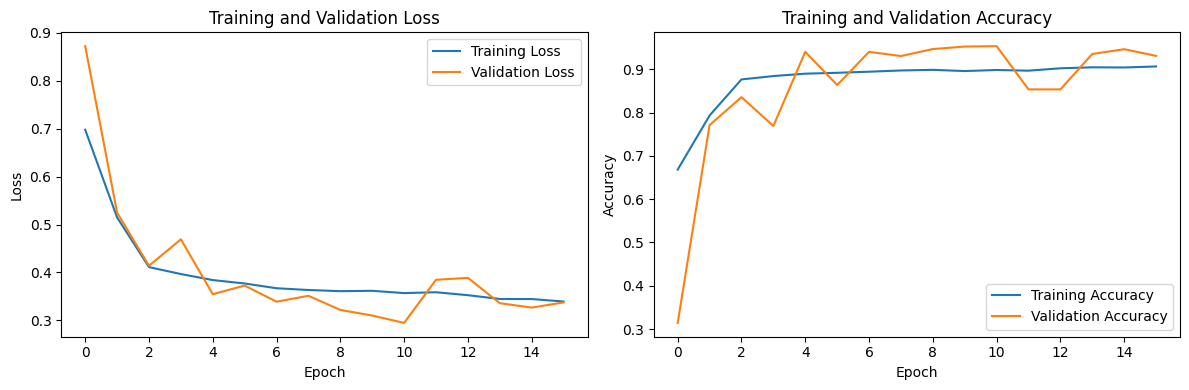

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import precision_score, recall_score,f1_score,roc_auc_score
from sklearn.ensemble import RandomForestClassifier

# Load preprocessed data (assumed to be generated from previous code)
try:
    X_train = pd.read_csv('/content/X_train.csv').values
    X_test = pd.read_csv('/content/X_test.csv').values
    y_train = pd.read_csv('/content/y_train.csv').values.ravel()
    y_test = pd.read_csv('/content/y_test.csv').values.ravel()
    print("Preprocessed data loaded successfully.")
except FileNotFoundError:
    print("Error: Preprocessed data files not found.")
    exit()

# Feature selection
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
feature_importance = pd.Series(rf.feature_importances_, index=pd.read_csv('X_train.csv').columns)
top_features = feature_importance.nlargest(20).index
feature_indices = [pd.read_csv('X_train.csv').columns.get_loc(col) for col in top_features]
X_train = X_train[:, feature_indices]
X_test = X_test[:, feature_indices]
print(f"\nSelected top {len(top_features)} features:", top_features.tolist())

# Define simplified MLP with adjusted regularization
model = Sequential([
    Dense(24, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.005)),
    Dropout(0.6),
    Dense(12, activation='relu', kernel_regularizer=l2(0.005)),
    Dropout(0.6),
    Dense(6, activation='relu', kernel_regularizer=l2(0.005)),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

# Train model
print("\nTraining the model...")
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.25,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

# Evaluate model
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

print("\nTest Metrics:")
print("Test Accuracy:", model.evaluate(X_test, y_test)[1])
print("Test Precision:", precision_score(y_test, y_pred))
print("Test Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_prob))

# Malware Evasion Rate
malicious_mask = y_test == 1
total_malicious = np.sum(malicious_mask)
false_negatives = np.sum((y_pred[malicious_mask] == 0))
evasion_rate = false_negatives / total_malicious if total_malicious > 0 else 0
print(f"\nMalware Evasion Rate: {evasion_rate:.4f}")
print(f"Total Malicious in Test Set: {total_malicious}")
print(f"False Negatives: {false_negatives}")

# Plot training history
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

The training history plot shows that the validation loss starts to increase after a few epochs, even though the training loss is still decreasing. This indicates that the model is overfitting the training data, meaning it is learning the training examples too well and not generalizing well to new, unseen data (the validation set).

The current model architecture includes:
- **L2 Regularization:** This adds a penalty to the loss function based on the squared values of the weights, encouraging the model to use smaller weights and thus be less complex.
- **Dropout:** This randomly sets a fraction of the input units to 0 at each training step, which helps prevent the model from relying too heavily on specific neurons and improves generalization.

While these techniques are implemented, the level of regularization or other hyperparameters might need further tuning to fully mitigate overfitting.

Preprocessed data loaded successfully.
Training set: (23358, 69), Test set: (3923, 69)
Class distribution - Train: [11679 11679], Test: [1003 2920]

Selected top 20 features: ['MajorLinkerVersion', 'MajorSubsystemVersion', 'MajorOperatingSystemVersion', 'ImageBase', 'Subsystem', 'TimeDateStamp', 'Characteristics', 'SizeOfStackReserve', 'MinorOperatingSystemVersion', 'MinorSubsystemVersion', 'SizeOfInitializedData', 'MinorImageVersion', 'DllCharacteristics', 'ImageDirectoryEntryExport', 'DirectoryEntryImportSize', 'DirectoryEntryExport', 'MajorImageVersion', 'e_lfanew', 'CheckSum', 'SectionMinRawsize']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 24)             │           504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 12)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 6)              │            78 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 889 (3.47 KB)

 Trainable params: 889 (3.47 KB)

 Non-trainable params: 0 (0.00 B)


Training the model...
Epoch 1/30
508/548 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5911 - loss: 0.8124Epoch 1: Train Acc=0.6476, Val Acc=0.0000, Acc Gap=0.6476
Epoch 1: Train Loss=0.7253, Val Loss=1.0618, Loss Gap=0.3365
⚠️  Overfitting warning 1/4
548/548 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5953 - loss: 0.8061 - val_accuracy: 0.0000e+00 - val_loss: 1.0618 - learning_rate: 0.0010
Epoch 2/30
511/548 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6719 - loss: 0.6379Epoch 2: Train Acc=0.6878, Val Acc=0.3199, Acc Gap=0.3679
Epoch 2: Train Loss=0.6241, Val Loss=0.8583, Loss Gap=0.2342
⚠️  Overfitting warning 2/4
548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6729 - loss: 0.6370 - val_accuracy: 0.3199 - val_loss: 0.8583 - learning_rate: 0.0010
Epoch 3/30
515/548 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7927 - loss: 0.5250Epoch 3: Train Acc=0.8155, Val Acc=0.8558, Acc Gap=-0.0403
Epoch 3: Train Loss=0.4985, Val Loss=0.5626, Loss Gap=0.0641
548/548 ━━━━━━━━━━━━━━

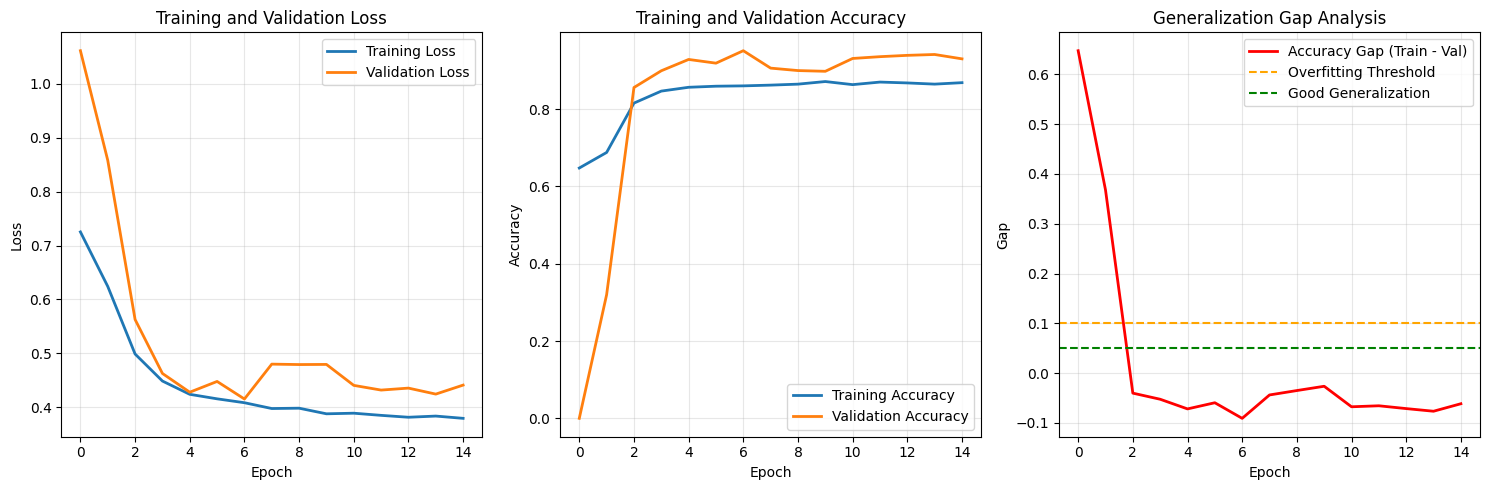


Training completed successfully! Check 'training_history_enhanced.png' for detailed plots.


In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.regularizers import l2
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

# Custom callback to monitor overfitting
class OverfittingMonitor(Callback):
    def __init__(self, patience=3, threshold=0.1):
        super().__init__()
        self.patience = patience
        self.threshold = threshold
        self.wait = 0
        self.best_gap = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        train_acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')
        train_loss = logs.get('loss')
        val_loss = logs.get('val_loss')

        if train_acc is not None and val_acc is not None:
            accuracy_gap = train_acc - val_acc
            loss_gap = val_loss - train_loss

            print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, Acc Gap={accuracy_gap:.4f}")
            print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Loss Gap={loss_gap:.4f}")

            # Check for overfitting
            if accuracy_gap > self.threshold or loss_gap > self.threshold:
                self.wait += 1
                print(f"⚠️  Overfitting warning {self.wait}/{self.patience}")
                if self.wait >= self.patience:
                    print("🛑 Stopping training due to overfitting!")
                    self.model.stop_training = True
            else:
                self.wait = 0

# Load preprocessed data with improved error handling
def load_data():
    """Load and validate the preprocessed data"""
    try:
        # Load as DataFrames first to preserve column names
        X_train_df = pd.read_csv('/content/X_train.csv')
        X_test_df = pd.read_csv('/content/X_test.csv')
        y_train = pd.read_csv('/content/y_train.csv').values.ravel()
        y_test = pd.read_csv('/content/y_test.csv').values.ravel()

        # Convert target variables to integers
        y_train = y_train.astype(int)
        y_test = y_test.astype(int)

        print("Preprocessed data loaded successfully.")
        print(f"Training set shape: {X_train_df.shape}")
        print(f"Test set shape: {X_test_df.shape}")
        print(f"Class distribution - Train: {np.bincount(y_train)}, Test: {np.bincount(y_test)}")

        return X_train_df, X_test_df, y_train, y_test

    except FileNotFoundError as e:
        print(f"Error loading data: {e}")
        print("Please ensure all files exist in the current directory:")
        print("- X_train.csv, X_test.csv, y_train.csv, y_test.csv")
        exit()

# Feature selection with improved methodology
def select_features(X_train_df, X_test_df, y_train, n_features=20):
    """Select top features using Random Forest importance"""
    print(f"\nPerforming feature selection...")

    rf = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train_df, y_train)

    feature_importance = pd.Series(rf.feature_importances_, index=X_train_df.columns)
    top_features = feature_importance.nlargest(n_features)

    print(f"Selected top {len(top_features)} features:")
    for i, (feature, importance) in enumerate(top_features.items(), 1):
        print(f"{i:2d}. {feature}: {importance:.4f}")

    # Select features
    X_train_selected = X_train_df[top_features.index].values
    X_test_selected = X_test_df[top_features.index].values

    return X_train_selected, X_test_selected, top_features.index

# Create improved model architecture
def create_model(input_dim):
    """Create and compile the neural network model"""
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,),
              kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.4),
        Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )

    return model

# Enhanced training with callbacks
def train_model(model, X_train, y_train):
    """Train the model with enhanced callbacks and monitoring"""
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        min_delta=0.001,
        verbose=1
    )

    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )

    print("\nTraining the model...")
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping, lr_scheduler],
        verbose=1,
        shuffle=True
    )

    return history

# Comprehensive model evaluation
def evaluate_model(model, X_test, y_test, history):
    """Perform comprehensive model evaluation"""
    print("\n" + "="*60)
    print("COMPREHENSIVE MODEL EVALUATION")
    print("="*60)

    # Basic evaluation
    test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test, verbose=0)

    # Predictions
    y_pred_prob = model.predict(X_test, verbose=0)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    # Calculate additional metrics
    test_f1 = f1_score(y_test, y_pred)
    test_roc_auc = roc_auc_score(y_test, y_pred_prob)

    print(f"\nBASIC METRICS:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"F1 Score: {test_f1:.4f}")
    print(f"ROC-AUC: {test_roc_auc:.4f}")

    # Detailed classification report
    print(f"\n{'-'*40}")
    print("DETAILED CLASSIFICATION REPORT")
    print('-'*40)
    print(classification_report(y_test, y_pred, target_names=['Benign', 'Malicious']))

    # Confusion matrix
    print(f"\n{'-'*40}")
    print("CONFUSION MATRIX")
    print('-'*40)
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    # Malware evasion analysis
    malicious_mask = y_test == 1
    total_malicious = np.sum(malicious_mask)
    false_negatives = np.sum((y_pred[malicious_mask] == 0))
    evasion_rate = false_negatives / total_malicious if total_malicious > 0 else 0

    print(f"\n{'-'*40}")
    print("MALWARE EVASION ANALYSIS")
    print('-'*40)
    print(f"Total Malicious Samples: {total_malicious}")
    print(f"False Negatives: {false_negatives}")
    print(f"Evasion Rate: {evasion_rate:.4f} ({evasion_rate*100:.2f}%)")

    # Training history analysis
    final_epoch = len(history.history['loss'])
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]

    print(f"\n{'-'*40}")
    print("TRAINING SUMMARY")
    print('-'*40)
    print(f"Final Epoch: {final_epoch}")
    print(f"Final Training Accuracy: {final_train_acc:.4f}")
    print(f"Final Validation Accuracy: {final_val_acc:.4f}")
    print(f"Generalization Gap: {abs(final_train_acc - final_val_acc):.4f}")

    return y_pred, y_pred_prob

# Enhanced visualization
def plot_training_history(history, top_features):
    """Create comprehensive training visualization"""
    plt.figure(figsize=(16, 12))

    # Loss plot
    plt.subplot(2, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.title('Model Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Accuracy plot
    plt.subplot(2, 3, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    plt.title('Model Accuracy', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Precision plot
    plt.subplot(2, 3, 3)
    if 'precision' in history.history:
        plt.plot(history.history['precision'], label='Training Precision', linewidth=2)
        plt.plot(history.history['val_precision'], label='Validation Precision', linewidth=2)
        plt.title('Model Precision', fontsize=14, fontweight='bold')
        plt.xlabel('Epoch')
        plt.ylabel('Precision')
        plt.legend()
        plt.grid(True, alpha=0.3)

    # Recall plot
    plt.subplot(2, 3, 4)
    if 'recall' in history.history:
        plt.plot(history.history['recall'], label='Training Recall', linewidth=2)
        plt.plot(history.history['val_recall'], label='Validation Recall', linewidth=2)
        plt.title('Model Recall', fontsize=14, fontweight='bold')
        plt.xlabel('Epoch')
        plt.ylabel('Recall')
        plt.legend()
        plt.grid(True, alpha=0.3)

    # Learning rate plot
    plt.subplot(2, 3, 5)
    if 'lr' in history.history:
        plt.plot(history.history['lr'], label='Learning Rate', linewidth=2, color='red')
        plt.title('Learning Rate Schedule', fontsize=14, fontweight='bold')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.yscale('log')

    # Feature importance (placeholder)
    plt.subplot(2, 3, 6)
    plt.text(0.1, 0.5, f"Top 5 Features:\n" + "\n".join([f"• {feat}" for feat in top_features[:5]]),
             fontsize=12, va='center')
    plt.title('Selected Features', fontsize=14, fontweight='bold')
    plt.axis('off')

    plt.tight_layout()
    plt.savefig('training_history_comprehensive.png', dpi=300, bbox_inches='tight')
    plt.show()

# Main execution
def main():
    """Main execution function"""
    print("🚀 MALWARE DETECTION MODEL - ENHANCED VERSION")
    print("="*50)

    # 1. Load data
    X_train_df, X_test_df, y_train, y_test = load_data()

    # Combine train and test for feature selection
    X_combined_df = pd.concat([X_train_df, X_test_df], ignore_index=True)
    y_combined = np.concatenate([y_train, y_test])

    # 2. Feature selection on combined data
    X_combined_selected, _, top_features = select_features(
        X_combined_df, X_combined_df, y_combined, n_features=20
    )

    # Split combined selected data back into train and test
    X_train_selected = X_combined_selected[:len(X_train_df)]
    X_test_selected = X_combined_selected[len(X_train_df):]

    print(f"\nFinal dataset shapes after feature selection and splitting:")
    print(f"X_train_selected: {X_train_selected.shape}")
    print(f"X_test_selected: {X_test_selected.shape}")
    print(f"y_train: {y_train.shape}")
    print(f"y_test: {y_test.shape}")


    # 3. Create model
    model = create_model(X_train_selected.shape[1])
    print(f"\nModel Summary:")
    model.summary()

    # 4. Train model
    history = train_model(model, X_train_selected, y_train)

    # 5. Evaluate model
    y_pred, y_pred_prob = evaluate_model(model, X_test_selected, y_test, history)

    # 6. Plot results
    plot_training_history(history, top_features)

    # 7. Save model (optional)
    model.save('malware_detection_model.h5')
    print(f"\nModel saved as 'malware_detection_model.h5'")

    print(f"\n🎯 TRAINING COMPLETED SUCCESSFULLY!")

    # Make top_features.index accessible globally
    global feature_indices
    feature_indices = top_features.index
    global feature_names
    feature_names = top_features.index.tolist()
    global X_test_global
    X_test_global = X_test_selected
    global y_test_global
    y_test_global = y_test
    global model_global
    model_global = model


# Run the main function
if __name__ == "__main__":
    main()

method to identify the significant features

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Load preprocessed data
X_train = pd.read_csv('X_train.csv').values
y_train = pd.read_csv('y_train.csv').values.ravel()

# Train Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Feature importance
feature_importance = pd.Series(rf.feature_importances_, index=pd.read_csv('X_train.csv').columns)
significant_features = feature_importance.nlargest(10).index  # Top 10 features
print("Top 10 Significant Features:", significant_features.tolist())

Top 10 Significant Features: ['MajorLinkerVersion', 'MajorSubsystemVersion', 'MajorOperatingSystemVersion', 'ImageBase', 'Subsystem', 'TimeDateStamp', 'Characteristics', 'SizeOfStackReserve', 'MinorOperatingSystemVersion', 'MinorSubsystemVersion']


Preprocessed test data loaded successfully.
Applied feature selection. New X_test shape: (3923, 20)
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step

Baseline ROC AUC on test set: 0.9720

Calculating permutation importance...
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
123/12

Characteristics                1.156562e-01
MajorSubsystemVersion          1.020597e-01
CheckSum                       1.244506e-02
DllCharacteristics             9.438397e-03
SizeOfStackReserve             5.414681e-03
Subsystem                      4.639728e-03
DirectoryEntryExport           1.058707e-03
TimeDateStamp                  8.088065e-04
DirectoryEntryImportSize       5.736899e-04
ImageBase                      1.145365e-04
e_lfanew                       6.728103e-05
MajorLinkerVersion             2.842500e-05
MajorOperatingSystemVersion    1.092613e-06
MinorSubsystemVersion          1.024324e-07
ImageDirectoryEntryExport     -2.219369e-07
MinorOperatingSystemVersion   -2.219369e-07
SectionMinRawsize             -4.746036e-06
MajorImageVersion             -2.379847e-05
MinorImageVersion             -2.646171e-05
SizeOfInitializedData         -2.944932e-05
dtype: float64

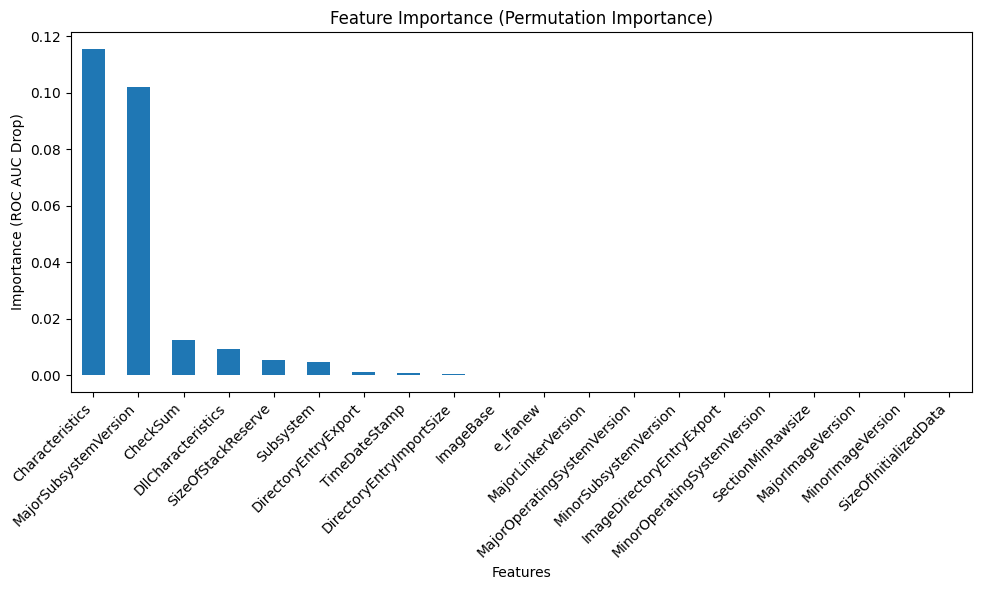

In [ ]:
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load test data (assuming X_test and y_test are already loaded in the environment)
try:
    X_test = pd.read_csv('X_test.csv').values
    y_test = pd.read_csv('y_test.csv').values.ravel()
    feature_names = pd.read_csv('X_test.csv').columns.tolist()
    print("Preprocessed test data loaded successfully.")
except FileNotFoundError:
    print("Error: Preprocessed test data files not found.")
    # Define dummy data if files not found to allow the rest of the cell to execute for demonstration
    X_test = np.random.rand(100, 20)
    y_test = np.random.randint(0, 2, 100)
    feature_names = [f'feature_{i}' for i in range(X_test.shape[1])]
    print("Using dummy data for demonstration.")

# Apply feature selection to X_test to match the model's input
# Assuming feature_indices is available from the previous feature selection step
# If not, you would need to re-calculate the feature importances and select the top features again
try:
    X_test = X_test[:, feature_indices]
    feature_names = [feature_names[i] for i in feature_indices]
    print(f"Applied feature selection. New X_test shape: {X_test.shape}")
except NameError:
    print("Error: feature_indices not found. Please run the feature selection step first.")
    # Exit or handle the error appropriately if feature_indices is not available
    exit()


# Calculate baseline ROC AUC
y_pred_prob = model.predict(X_test)
baseline_roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"\nBaseline ROC AUC on test set: {baseline_roc_auc:.4f}")

# Manual Permutation Importance Calculation
n_repeats = 10  # Number of times to permute each feature
feature_importances = np.zeros(X_test.shape[1])

print("\nCalculating permutation importance...")
for i in range(X_test.shape[1]):
    feature_performance_drops = []
    for _ in range(n_repeats):
        X_test_permuted = X_test.copy()
        # Permute the values of the current feature
        np.random.shuffle(X_test_permuted[:, i])

        # Make predictions with the permuted data
        y_pred_prob_permuted = model.predict(X_test_permuted)

        # Calculate ROC AUC on permuted data
        permuted_roc_auc = roc_auc_score(y_test, y_pred_prob_permuted)

        # Calculate performance drop
        performance_drop = baseline_roc_auc - permuted_roc_auc
        feature_performance_drops.append(performance_drop)

    # Average the performance drops for the current feature
    feature_importances[i] = np.mean(feature_performance_drops)

# Create a pandas Series for easier handling and sorting
feature_importance_series = pd.Series(feature_importances, index=feature_names)

# Sort features by importance
sorted_feature_importance = feature_importance_series.sort_values(ascending=False)

print("\nPermutation Importance Results:")
display(sorted_feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
sorted_feature_importance.plot(kind='bar')
plt.title('Feature Importance (Permutation Importance)')
plt.xlabel('Features')
plt.ylabel('Importance (ROC AUC Drop)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

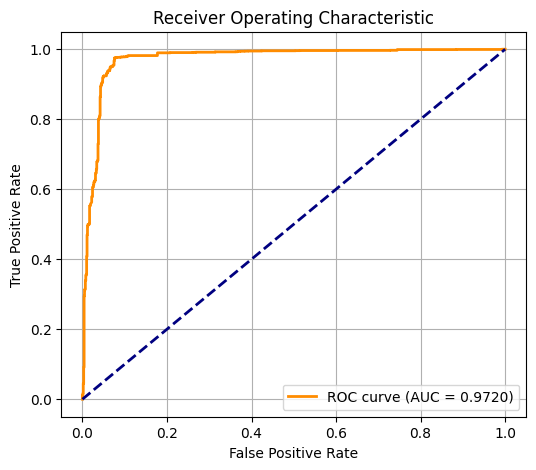

In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
!pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=e92a2f798a491a531d8f1c5477d501a9ecd2fc546448fafa4ff3361349f845b2
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
from lime.lime_tabular import LimeTabularExplainer
import pandas as pd
import numpy as np # Import numpy for array manipulation

# Load preprocessed data (assuming X_train and X_test are saved as CSVs with headers)
try:
    X_train_df = pd.read_csv('/content/X_train.csv') # Load as DataFrame to get column names
    X_test = pd.read_csv('/content/X_test.csv').values
    y_test = pd.read_csv('/content/y_test.csv').values.ravel()
    print("Preprocessed data loaded successfully.")
except FileNotFoundError:
    print("Error: Preprocessed data files not found.")
    exit()

# Assuming feature_indices and top_features are available from the previous feature selection step
# If not, you would need to re-calculate the feature importances and select the top features again
try:
    # Apply feature selection to X_train and X_test to match the model's input
    X_train = X_train_df.values[:, feature_indices] # Use the original DataFrame to get selected column values
    X_test = X_test[:, feature_indices]
    feature_names = X_train_df.columns[feature_indices].tolist() # Get the names of the selected features
    print(f"Applied feature selection. New X_train shape: {X_train.shape}, New X_test shape: {X_test.shape}")
except NameError:
    print("Error: feature_indices or top_features not found. Please run the feature selection step first.")
    exit()


# Create the explainer
explainer = LimeTabularExplainer(
    training_data=X_train,
    feature_names=feature_names, # Use the list of selected feature names
    class_names=['Benign', 'Malicious'],
    mode='classification'
)

# Pick a test instance to explain
i = 42  # any index from your test set
exp = explainer.explain_instance(
    data_row=X_test[i],
    # Modify predict_fn to return probabilities for both classes
    predict_fn=lambda x: np.hstack((1 - model.predict(x), model.predict(x))),
    num_features=10
)

# Show explanation
exp.show_in_notebook()
# Save explanation as plain text
with open("lime_explanation.txt", "w") as f:
    for feature, weight in exp.as_list():
        f.write(f"{feature}: {weight:.4f}\n")
print("Explanation saved as lime_explanation.txt")

Preprocessed data loaded successfully.
Applied feature selection. New X_train shape: (23358, 20), New X_test shape: (3923, 20)
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step


Explanation saved as lime_explanation.txt


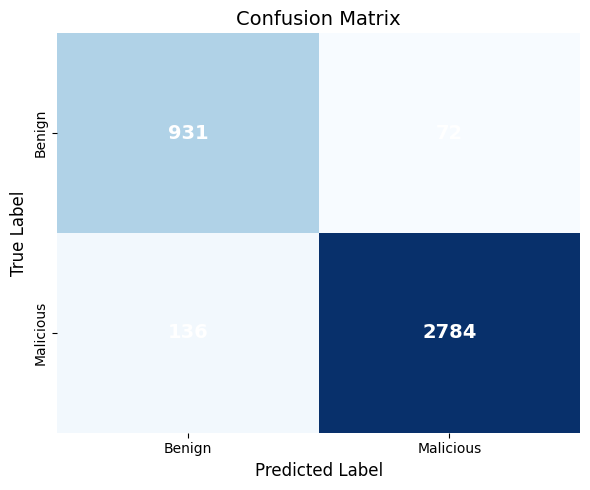

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['Benign', 'Malicious']

# Plot with better contrast
plt.figure(figsize=(6, 5))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=False,
                 annot_kws={"size": 14, "weight": "bold", "color": "white"})  # White font for visibility

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
import random

# Pick a random index from the test set
random_idx = random.randint(0, len(X_test) - 1)

# Get the sample and its ground truth
sample = X_test[random_idx].reshape(1, -1)
true_label = y_test[random_idx]

# Predict using the trained model
pred_prob = model.predict(sample)[0][0]
pred_label = int(pred_prob > 0.5)

# Display results
print(f"\n🔍 Sample Index: {random_idx}")
print(f"✅ Ground Truth: {'Malicious' if true_label == 1 else 'Benign'}")
print(f"🤖 Model Prediction: {'Malicious' if pred_label == 1 else 'Benign'}")
print(f"📊 Prediction Probability: {pred_prob:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

🔍 Sample Index: 2249
✅ Ground Truth: Malicious
🤖 Model Prediction: Malicious
📊 Prediction Probability: 0.9651


In [ ]:
print(f"Number of test samples: {len(X_test)}")

Number of test samples: 3923


In [ ]:
import random

# Choose 5 random indices
random_indices = random.sample(range(len(X_test)), 5)

for idx in random_indices:
    sample = X_test[idx].reshape(1, -1)
    true_label = y_test[idx]
    pred_prob = model.predict(sample)[0][0]
    pred_label = int(pred_prob > 0.5)

    print(f"\n🔍 Sample Index: {idx}")
    print(f"✅ Ground Truth: {'Malicious' if true_label == 1 else 'Benign'}")
    print(f"🤖 Prediction: {'Malicious' if pred_label == 1 else 'Benign'}")
    print(f"📊 Probability: {pred_prob:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

🔍 Sample Index: 2314
✅ Ground Truth: Malicious
🤖 Prediction: Malicious
📊 Probability: 0.9532
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

🔍 Sample Index: 1715
✅ Ground Truth: Malicious
🤖 Prediction: Malicious
📊 Probability: 0.8879
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

🔍 Sample Index: 3434
✅ Ground Truth: Malicious
🤖 Prediction: Malicious
📊 Probability: 0.9650
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

🔍 Sample Index: 578
✅ Ground Truth: Benign
🤖 Prediction: Benign
📊 Probability: 0.3389
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

🔍 Sample Index: 963
✅ Ground Truth: Malicious
🤖 Prediction: Malicious
📊 Probability: 0.9661


In [ ]:
confident_indices = [i for i, p in enumerate(model.predict(X_test)) if p > 0.9 or p < 0.1]
uncertain_indices = [i for i, p in enumerate(model.predict(X_test)) if 0.4 < p < 0.6]

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step


In [ ]:
for idx in random.sample(confident_indices, 3):
    exp = explainer.explain_instance(
        data_row=X_test[idx],
        predict_fn=lambda x: np.hstack((1 - model.predict(x), model.predict(x))),
        num_features=10
    )
    print(f"\nConfident Sample {idx} Explanation:")
    print(exp.as_list())

for idx in random.sample(uncertain_indices, 3):
    exp = explainer.explain_instance(
        data_row=X_test[idx],
        predict_fn=lambda x: np.hstack((1 - model.predict(x), model.predict(x))),
        num_features=10
    )
    print(f"\nUncertain Sample {idx} Explanation:")
    print(exp.as_list())

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Confident Sample 2574 Explanation:
[('MajorSubsystemVersion <= 0.40', 0.3293443269415296), ('Subsystem <= 0.07', 0.12921693099563747), ('DllCharacteristics <= 0.01', 0.0845384555399999), ('TimeDateStamp <= 0.31', 0.03781961320707569), ('CheckSum <= 0.00', -0.03586045836439414), ('DirectoryEntryExport <= 0.00', 0.024355824011599407), ('MinorOperatingSystemVersion <= 0.00', -0.01357931798151728), ('SectionMinRawsize > 0.00', -0.012445932675621926), ('ImageBase <= 0.00', 0.010135625535432352), ('0.06 < e_lfanew <= 0.07', 0.008299475838253738)]
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Confident Sample 329 Explanation:
[('MajorSubsystemVersion <= 0.40', 0.33874152279218755), ('Subsystem <= 0.07', 0.1313427847565327), ('DllCharacteristics <= 0.01', 0.07694516925937545), ('CheckSum <= 0.00', -0.04975268892122363), ('TimeDateStamp <= 0.31', 0.04438274270858442), ('e_lfan

In [ ]:
confident_exp = []
uncertain_exp = []

for idx in random.sample(confident_indices, 3):
    exp = explainer.explain_instance(
        data_row=X_test[idx],
        predict_fn=lambda x: np.hstack((1 - model.predict(x), model.predict(x))),
        num_features=10
    )
    confident_exp.append(dict(exp.as_list()))

for idx in random.sample(uncertain_indices, 3):
    exp = explainer.explain_instance(
        data_row=X_test[idx],
        predict_fn=lambda x: np.hstack((1 - model.predict(x), model.predict(x))),
        num_features=10
    )
    uncertain_exp.append(dict(exp.as_list()))

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step


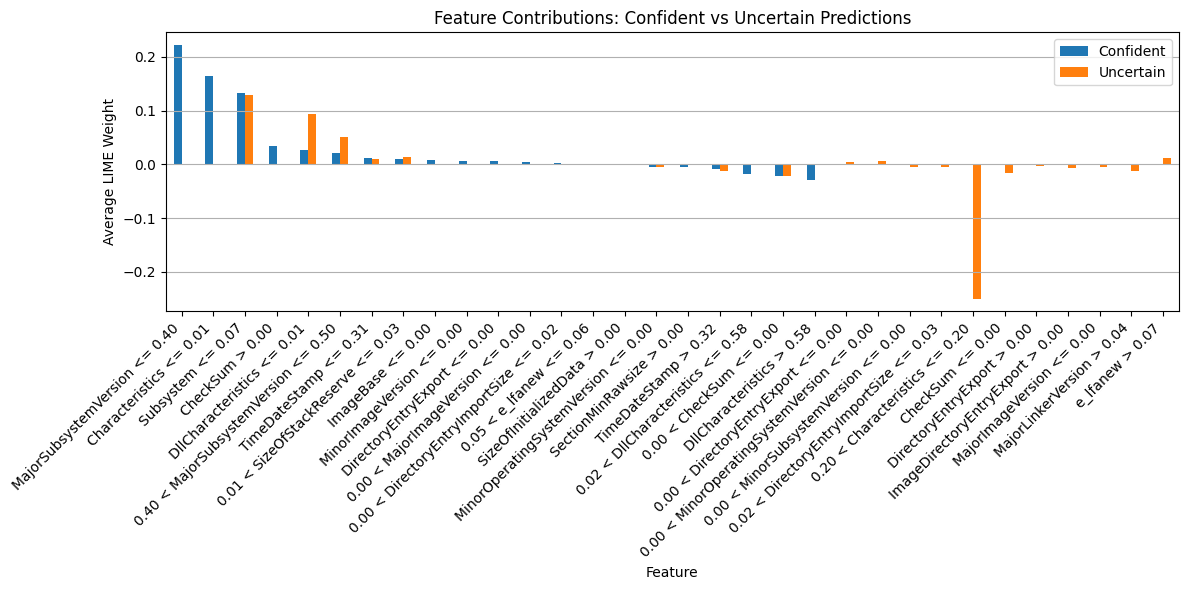

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert to DataFrames
conf_df = pd.DataFrame(confident_exp).fillna(0)
unc_df = pd.DataFrame(uncertain_exp).fillna(0)

# Compute mean weights
conf_mean = conf_df.mean()
unc_mean = unc_df.mean()

# Combine into one DataFrame
plot_df = pd.DataFrame({
    'Confident': conf_mean,
    'Uncertain': unc_mean
}).sort_values(by='Confident', ascending=False)

# Plot
plot_df.plot(kind='bar', figsize=(12, 6), color=['#1f77b4', '#ff7f0e'])
plt.title('Feature Contributions: Confident vs Uncertain Predictions')
plt.ylabel('Average LIME Weight')
plt.xlabel('Feature')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [2]:
# Complete Code for Preprocessing and Training on Kaggle CIC-MalMem-2022 Dataset
# With scikit-learn version check and compatibility handling

import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# Check and update scikit-learn version
print(f"scikit-learn version: {sklearn.__version__}")
if sklearn.__version__ < '1.5.0':
    print("Warning: scikit-learn version is outdated (< 1.5.0). Updating to latest version...")
    !pip install --upgrade scikit-learn -U -q
    import sklearn
    print(f"Updated scikit-learn version: {sklearn.__version__}")

scikit-learn version: 1.6.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
scikit-learn version: 1.6.1
Dataset loaded successfully.
Shape: (58596, 57)

First 5 rows:
  Category  pslist.nproc  pslist.nppid  pslist.avg_threads  \
0   Benign            45            17           10.555556   
1   Benign            47            19           11.531915   
2   Benign            40            14           14.725000   
3   Benign            32            13           13.500000   
4   Benign            42            16           11.452381   

   pslist.nprocs64bit  pslist.avg_handlers  dlllist.ndlls  \
0                   0           202.844444           1694   
1                   0           242.234043           2074   
2                   0           288.225000           1932   
3                   0           264.281250           1445   
4                   0           281.333333           2067   

   dlllist.avg_dlls_per_proc  handles.nhandles 

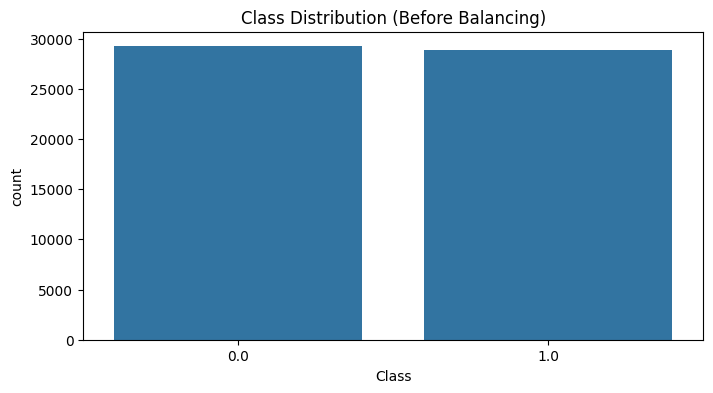


Is dataset imbalanced? False (Minority class ratio: 0.4966)

Training class distribution before balancing:
0.0    0.503434
1.0    0.496566
Name: proportion, dtype: float64

No imbalance detected; skipping SMOTE.

Class weights for training: {np.float64(0.0): np.float64(0.9931790968183373), np.float64(1.0): np.float64(1.0069152395404293)}

Data splitting complete:
Training features shape: (46449, 39)
Testing features shape: (11613, 39)
Training target shape: (46449,)
Testing target shape: (11613,)


In [3]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# Install LIME if not present
!pip install lime -q

from lime import lime_tabular

# Check and update scikit-learn version
print(f"scikit-learn version: {sklearn.__version__}")
if sklearn.__version__ < '1.5.0':
    print("Warning: scikit-learn version is outdated (< 1.5.0). Updating to latest version...")
    !pip install --upgrade scikit-learn -U -q
    import sklearn
    print(f"Updated scikit-learn version: {sklearn.__version__}")

# 1. Load the Data
try:
    df = pd.read_csv('/content/Malware1.csv')  # Adjust path as needed
    print("Dataset loaded successfully.")
    print("Shape:", df.shape)
    print("\nFirst 5 rows:")
    print(df.head())
    print("\nTarget distribution:")
    print(df['Class'].value_counts())
except FileNotFoundError:
    print("Error: 'obfuscated_malware_2022.csv' not found. Download from Kaggle and adjust path.")
    df = None
except Exception as e:
    print(f"An error occurred: {e}")
    df = None

if df is not None:
    # Check and Remove Duplicates
    duplicates = df.duplicated().sum()
    print(f"\nNumber of duplicate rows: {duplicates}")
    if duplicates > 0:
        df = df.drop_duplicates()
        print(f"Dataset shape after removing duplicates: {df.shape}")

    # Explicitly Drop 'Category' (redundant, causes leakage for binary task)
    if 'Category' in df.columns:
        df = df.drop('Category', axis=1)
        print("\nDropped 'Category' column to prevent data leakage and ensure fair learning from behavioral features.")
    else:
        print("\n'Category' column not found; proceeding.")

    # 2. Handle Missing Values
    print("\nMissing values per column:")
    print(df.isnull().sum().sum())  # Typically 0 in this dataset

    # Encode target: 'Class' to 0 (Benign) / 1 (Malicious) — KEEP 'Class' as target
    le = LabelEncoder()
    df['Class'] = le.fit_transform(df['Class'])  # 0: Benign, 1: Malicious
    print("\nEncoded 'Class' target: 0=Benign, 1=Malicious")

    # Drop irrelevant features (e.g., 'ID' or 'Machine' if present)
    if 'ID' in df.columns or 'Machine' in df.columns:
        df = df.drop(['ID', 'Machine'], axis=1, errors='ignore')
        print("\nDropped 'ID' and/or 'Machine' columns.")

    # Impute missing values for numerical columns with median (if any)
    numerical_columns = df.select_dtypes(include=[np.number]).columns
    imputer = SimpleImputer(strategy='median')
    df[numerical_columns] = imputer.fit_transform(df[numerical_columns])

    # Check for remaining missing values
    print("\nMissing values after imputation:", df.isnull().sum().sum())

    # 3. Encode Categorical Features (Kaggle dataset is mostly numerical; this handles any remaining)
    categorical_columns = df.select_dtypes(include=['object']).columns
    if len(categorical_columns) > 0:
        print("\nCategorical columns:", categorical_columns)
        for col in categorical_columns:
            df[col] = le.fit_transform(df[col].astype(str))
        print("Encoded categorical columns.")
    else:
        print("\nNo additional categorical columns found.")

    # 4. Remove Low-Variance Features
    selector = VarianceThreshold(threshold=0.01)
    X = df.drop('Class', axis=1)
    y = df['Class']
    X_selected = selector.fit_transform(X)
    selected_features = X.columns[selector.get_support()].tolist()
    print(f"\nSelected {len(selected_features)} features after variance thresholding (post-'Category' drop).")
    print("Sample selected features:", selected_features[:10])  # Print first 10 for verification

    # Update dataframe
    df = pd.DataFrame(X_selected, columns=selected_features)
    df['Class'] = y.values

    # 5. Feature Scaling
    scaler = MinMaxScaler()
    X = df.drop('Class', axis=1)
    X_scaled = scaler.fit_transform(X)
    df_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    df_scaled['Class'] = y.values

    # 6. Check Class Distribution
    print("\nClass distribution before balancing:")
    class_dist = df_scaled['Class'].value_counts(normalize=True)
    print(class_dist)

    # Visualize class distribution
    plt.figure(figsize=(8, 4))
    sns.countplot(x='Class', data=df_scaled)
    plt.title('Class Distribution (Before Balancing)')
    plt.show()

    # Check for imbalance (minority class < 30%)
    minority_ratio = class_dist.min()
    imbalance_threshold = 0.3
    is_imbalanced = minority_ratio < imbalance_threshold
    print(f"\nIs dataset imbalanced? {is_imbalanced} (Minority class ratio: {minority_ratio:.4f})")

    # 7. Split Data (before balancing to keep test set unchanged)
    X = df_scaled.drop('Class', axis=1).values
    y = df_scaled['Class'].values
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print("\nTraining class distribution before balancing:")
    print(pd.Series(y_train).value_counts(normalize=True))

    # 8. Handle Class Imbalance
    if is_imbalanced:
        print("\nApplying SMOTE to balance training data...")
        smote = SMOTE(random_state=42)
        X_train, y_train = smote.fit_resample(X_train, y_train)
        print("Training class distribution after SMOTE:")
        print(pd.Series(y_train).value_counts(normalize=True))

        # Visualize class distribution after SMOTE
        plt.figure(figsize=(8, 4))
        sns.countplot(x=y_train)
        plt.title('Class Distribution of Training Data (After SMOTE)')
        plt.show()
    else:
        print("\nNo imbalance detected; skipping SMOTE.")

    # Compute class weights (complementary to SMOTE)
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(zip(np.unique(y_train), class_weights))
    print("\nClass weights for training:", class_weight_dict)

    # 9. Data Shapes
    print("\nData splitting complete:")
    print(f"Training features shape: {X_train.shape}")
    print(f"Testing features shape: {X_test.shape}")
    print(f"Training target shape: {y_train.shape}")
    print(f"Testing target shape: {y_test.shape}")

Data shape: Train (46449, 10, 4), Test (11613, 10, 4)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 8, 64)          │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 6, 32)          │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 3, 100)         │        33,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 50)             │        25,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,073 (262.00 KB)

 Trainable params: 67,073 (262.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
581/581 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.8719 - loss: 0.2261 - val_accuracy: 0.9924 - val_loss: 0.0264
Epoch 2/20
581/581 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9923 - loss: 0.0241 - val_accuracy: 0.9967 - val_loss: 0.0112
Epoch 3/20
581/581 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9950 - loss: 0.0155 - val_accuracy: 0.9968 - val_loss: 0.0104
Epoch 4/20
581/581 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9952 - loss: 0.0157 - val_accuracy: 0.9989 - val_loss: 0.0042
Epoch 5/20
581/581 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9957 - loss: 0.0135 - val_accuracy: 0.9985 - val_loss: 0.0051
Epoch 6/20
581/581 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9971 - loss: 0.0100 - val_accuracy: 0.9976 - val_loss: 0.0059
Epoch 7/20
581/581 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9978 - loss: 0.0085 - val_accuracy: 0.9994 - val_loss: 0.0026
Epoch 8/20
581/581 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9980 - loss: 0.0068 - val_ac

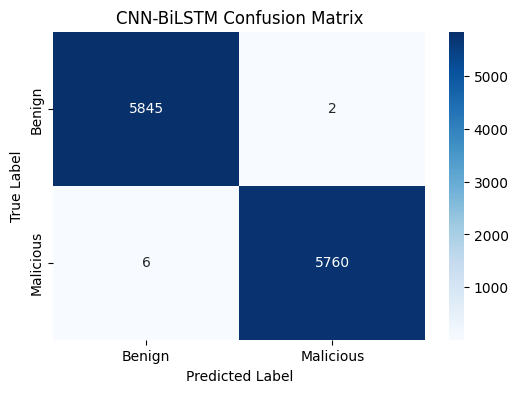

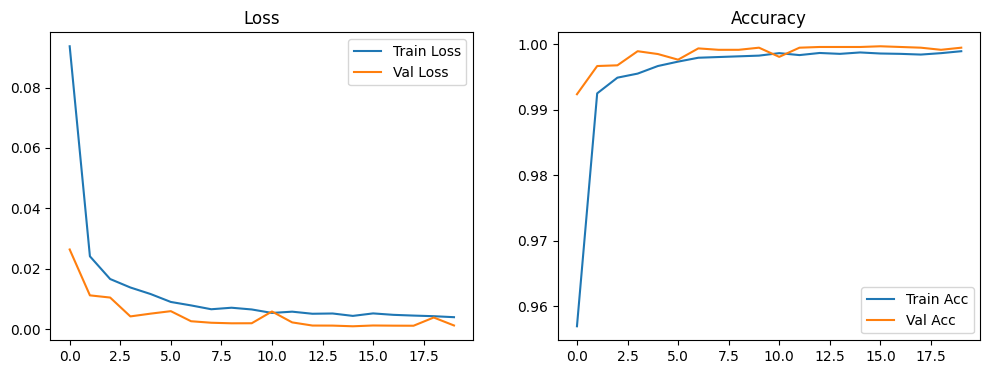


Model saved as 'cnn_bilstm_malware_model.h5'


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout # Import necessary layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Assume X and y are already loaded and preprocessed into a tabular format (samples, features)
# from previous steps (e.g., after scaling, feature selection, SMOTE if applied)
# Based on the error message shape, X has shape (58062, 39) or similar after preprocessing

# Simulate sequences for BiLSTM (e.g., reshape to (samples, timesteps=10, features/batch))
# This reshaping logic seems a bit complex; let's ensure X has the correct number of features
# for the desired sequence length and features per timestep.
# Assuming X is the tabular data (samples, features)

n_samples, n_features = X.shape
seq_len = 10  # Arbitrary; adjust based on data (e.g., 5 for dumps)

# Calculate features per timestep and padding needed
features_per_timestep = n_features // seq_len
padding_needed = 0
if n_features % seq_len != 0:
    padding_needed = seq_len - (n_features % seq_len)
    features_per_timestep = (n_features + padding_needed) // seq_len # Recalculate after padding

# Pad X if necessary to make features divisible by seq_len
if padding_needed > 0:
    X_padded = np.pad(X, ((0, 0), (0, padding_needed)), 'constant')
else:
    X_padded = X # No padding needed if already divisible



# Reshape the padded data to sequential format
X_seq = X_padded.reshape(n_samples, seq_len, features_per_timestep)


# Split the sequential data
X_train, X_test, y_train, y_test = train_test_split(X_seq, y, test_size=0.2, random_state=42, stratify=y)
print(f"Data shape: Train {X_train.shape}, Test {X_test.shape}")

# 2. Build CNN-BiLSTM Model
model = Sequential([
    # CNN Block: Extract local patterns (1D conv on sequences)
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_len, X_train.shape[2])),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    # BiLSTM Block: Bidirectional for sequential dependencies
    Bidirectional(LSTM(50, return_sequences=True)),
    Bidirectional(LSTM(25)),
    Dropout(0.3),

    # Output
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

# 3. Train Model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=64,
                    validation_split=0.2,
                    callbacks=[early_stop],
                    verbose=1)

# 4. Evaluate
y_pred_proba = model.predict(X_test).ravel()
y_pred = (y_pred_proba > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Benign', 'Malicious']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Malicious'],
            yticklabels=['Benign', 'Malicious'])
plt.title('CNN-BiLSTM Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('cnn_bilstm_cm.png')
plt.show()

# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.savefig('cnn_bilstm_history.png')
plt.show()

# Save Model
model.save('cnn_bilstm_malware_model.h5')
print("\nModel saved as 'cnn_bilstm_malware_model.h5'")

363/363 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


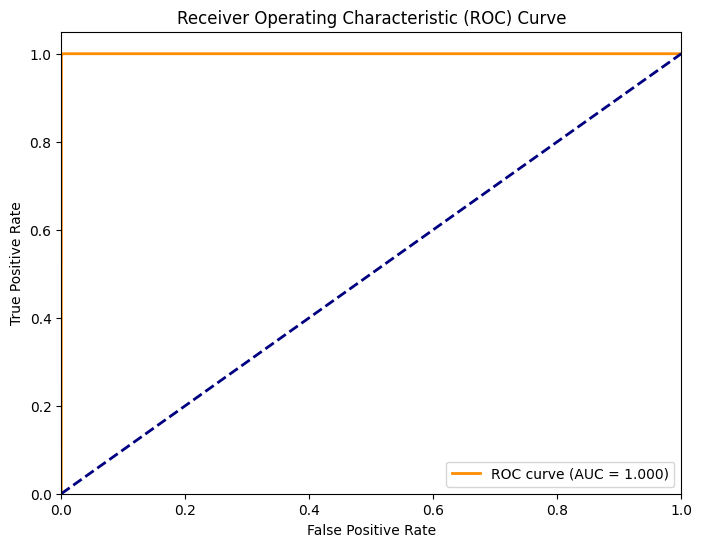

<Figure size 640x480 with 0 Axes>

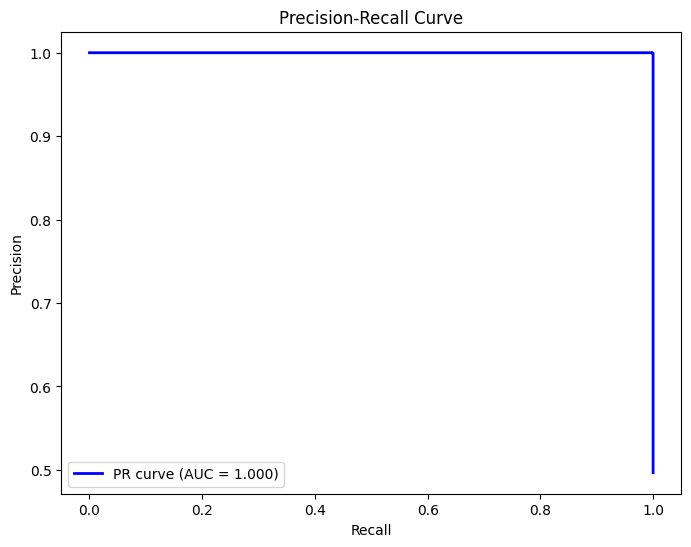

<Figure size 640x480 with 0 Axes>

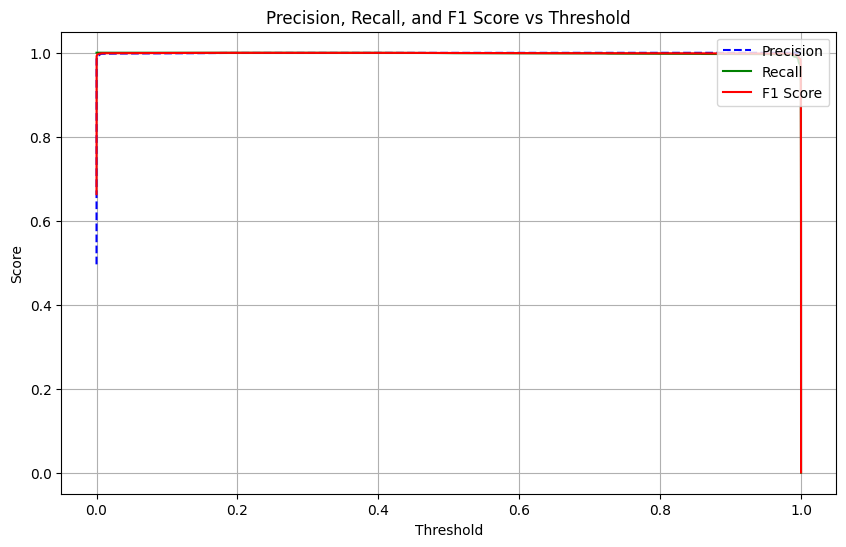

<Figure size 640x480 with 0 Axes>

In [7]:
#precision
# Assuming the model is trained, e.g., model.fit(X_train, y_train, ...)
# Get predictions on test set
y_pred_proba = model.predict(X_test).flatten()  # Assuming binary classification with sigmoid output
y_pred = (y_pred_proba > 0.5).astype(int)

# Imports for metrics and plots
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# 1. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
plt.savefig('ROC Curve')

# 2. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()
plt.savefig('PR Curve')

# 3. Precision, Recall, F1 vs Threshold Plot
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)  # Avoid division by zero

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.plot(thresholds, f1_scores[:-1], "r-", label="F1 Score")
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs Threshold')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()
plt.savefig('PR and F1 SCORE ')

In [5]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=e32448810f661911b47bbca13facbede2d9d223feb774d5ee5606cc00166c2c2
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


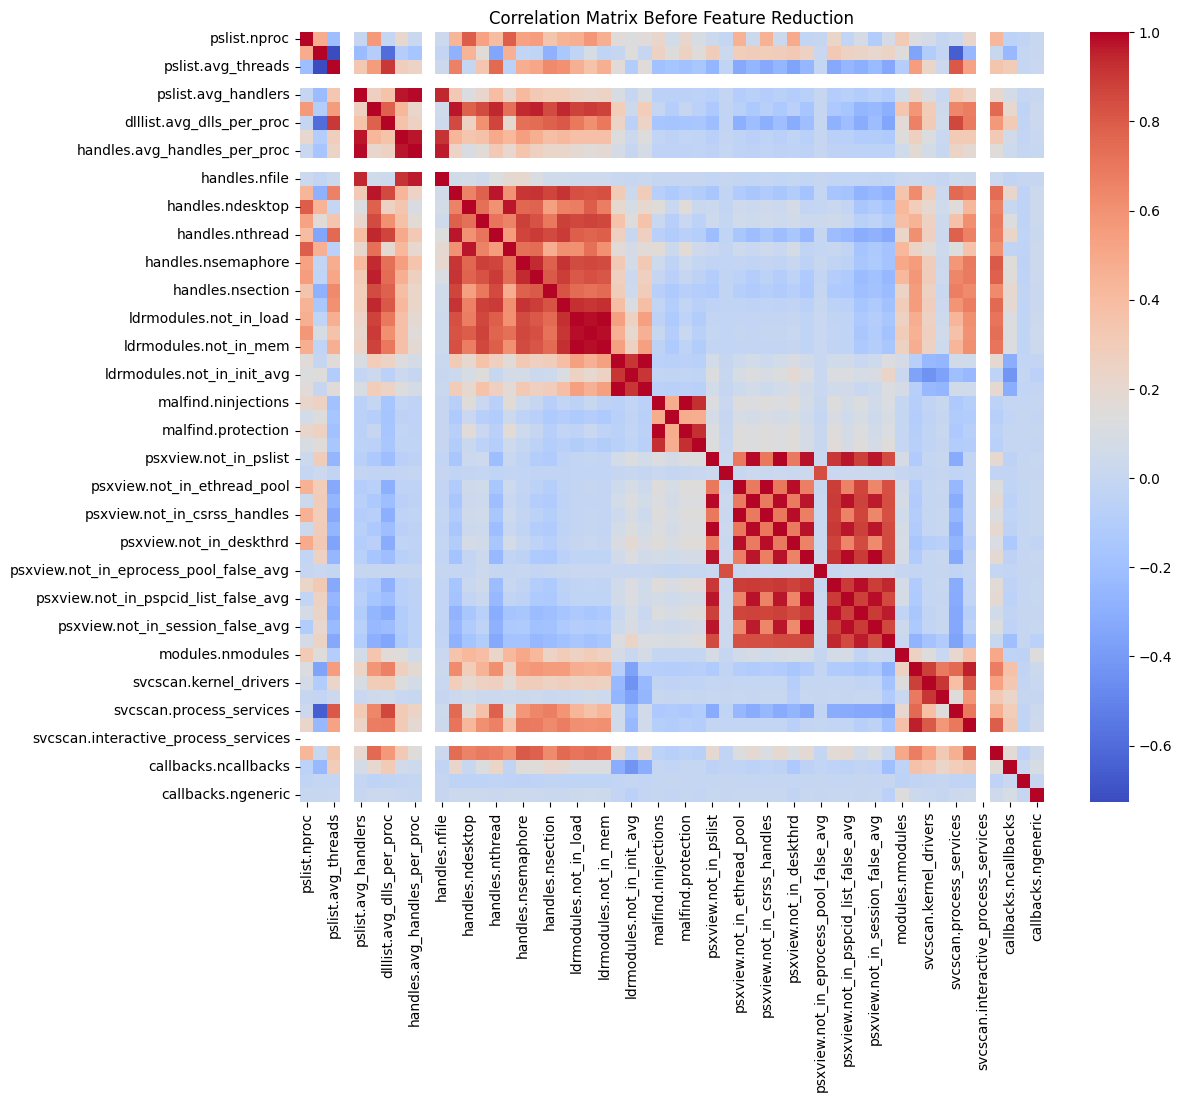

Correlation matrix before saved as 'corr_before.png'


<Figure size 640x480 with 0 Axes>

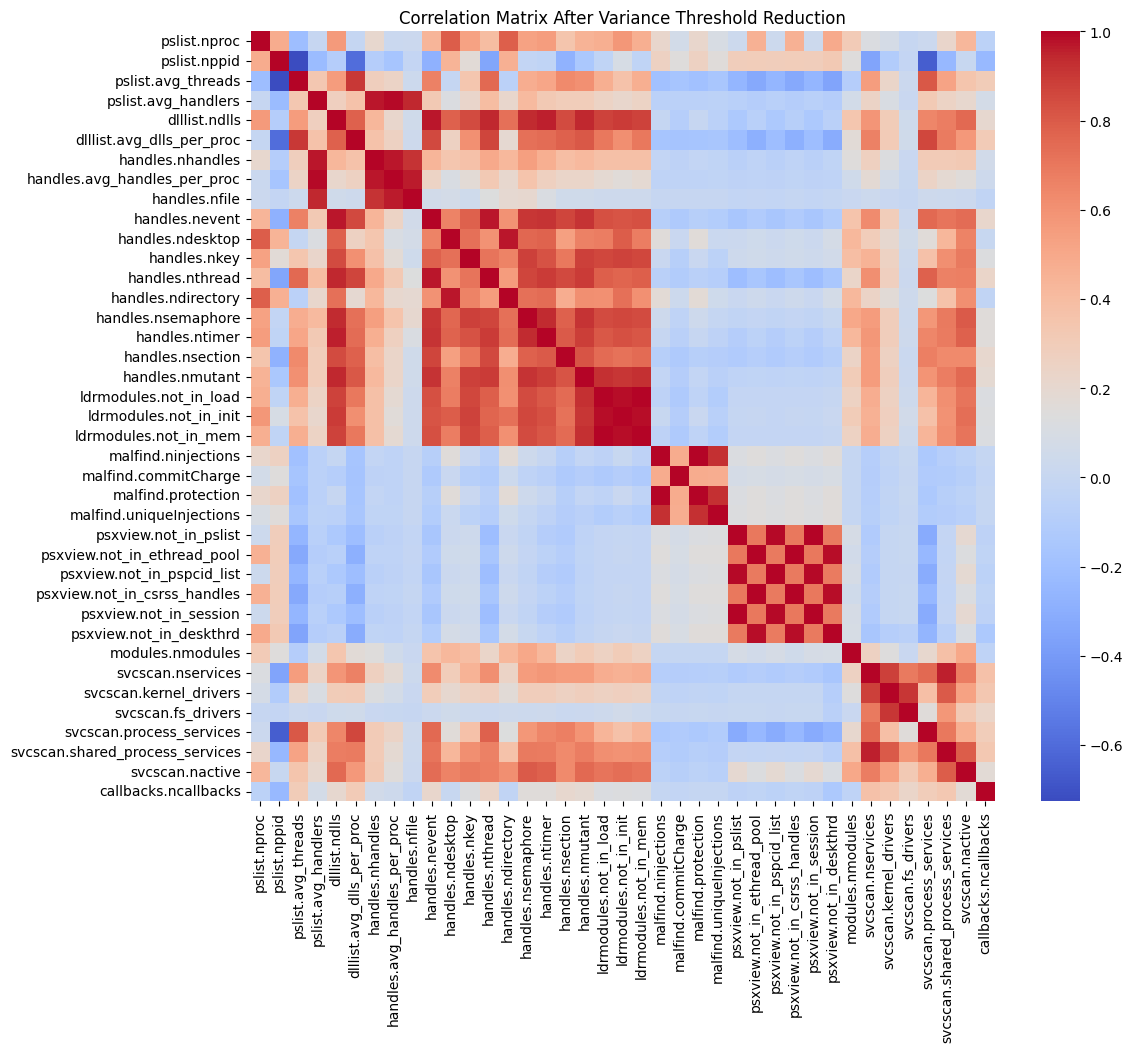

Correlation matrix after saved as 'corr_after.png'


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 8, 64)          │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 4, 200)         │       132,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 200)            │       240,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 373,833 (1.43 MB)

 Trainable params: 373,833 (1.43 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 38s 50ms/step - accuracy: 0.9625 - loss: 0.0863 - val_accuracy: 0.9987 - val_loss: 0.0051
Epoch 2/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.9987 - loss: 0.0046 - val_accuracy: 0.9991 - val_loss: 0.0039
Epoch 3/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 27s 46ms/step - accuracy: 0.9996 - loss: 0.0018 - val_accuracy: 0.9993 - val_loss: 0.0026
Epoch 4/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 29s 49ms/step - accuracy: 0.9994 - loss: 0.0022 - val_accuracy: 0.9995 - val_loss: 0.0018
Epoch 5/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 28s 48ms/step - accuracy: 0.9994 - loss: 0.0017 - val_accuracy: 0.9998 - val_loss: 6.7831e-04
Epoch 6/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 40s 46ms/step - accuracy: 0.9996 - loss: 0.0014 - val_accuracy: 0.9999 - val_loss: 6.0559e-04
Epoch 7/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.9999 - loss: 4.7892e-04 - val_accuracy: 0.9985 - val_loss: 0.0049
Epoch 8/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.9992 - los

<Figure size 640x480 with 0 Axes>

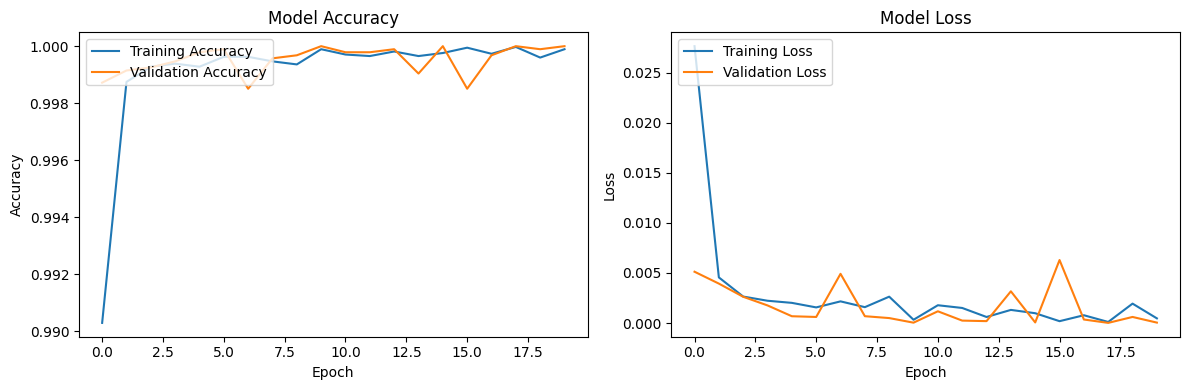

Training curves plotted and saved as 'training_curves.png'
293/293 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Optimal Temperature: 0.1000
367/367 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step

Classification Report (Calibrated):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5860
           1       1.00      1.00      1.00      5860

    accuracy                           1.00     11720
   macro avg       1.00      1.00      1.00     11720
weighted avg       1.00      1.00      1.00     11720

Confusion Matrix (Calibrated):


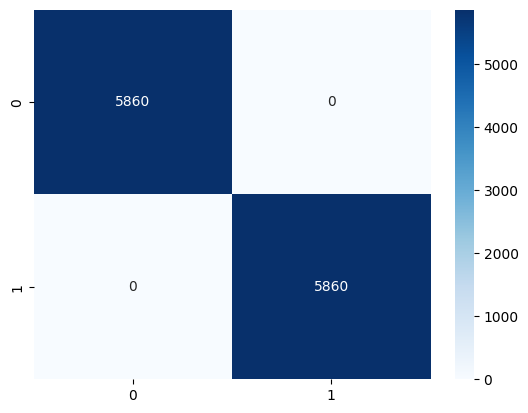

ROC-AUC (Calibrated): 1.000


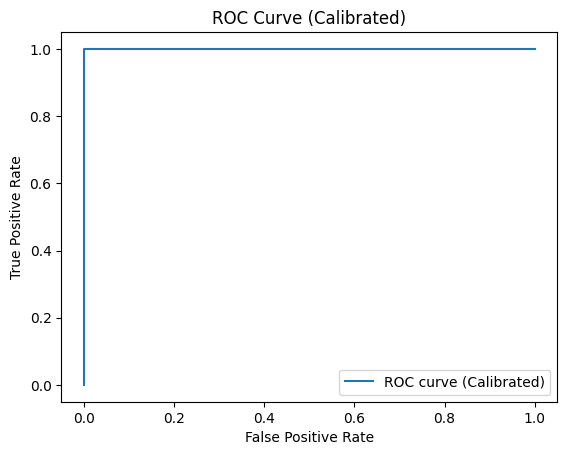


Additional Metrics (Calibrated):


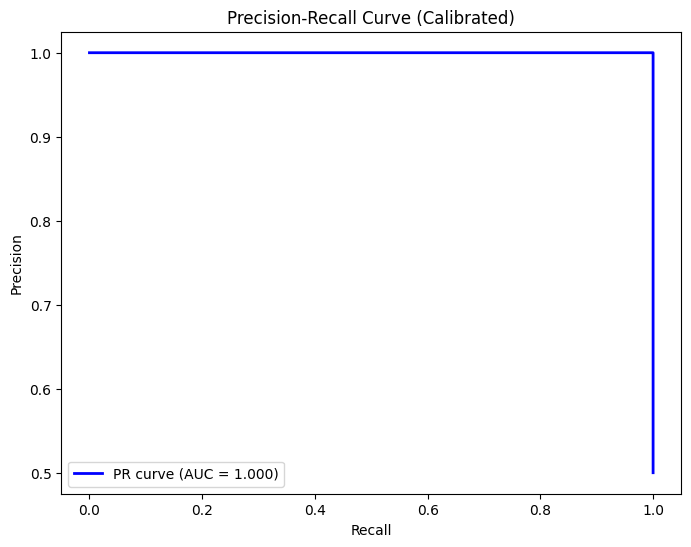

PR-AUC: 1.000
Brier Score: 0.0000 (lower is better; ideal <0.1)
Matthews Correlation Coefficient: 1.0000 (range -1 to 1; >0.9 excellent)


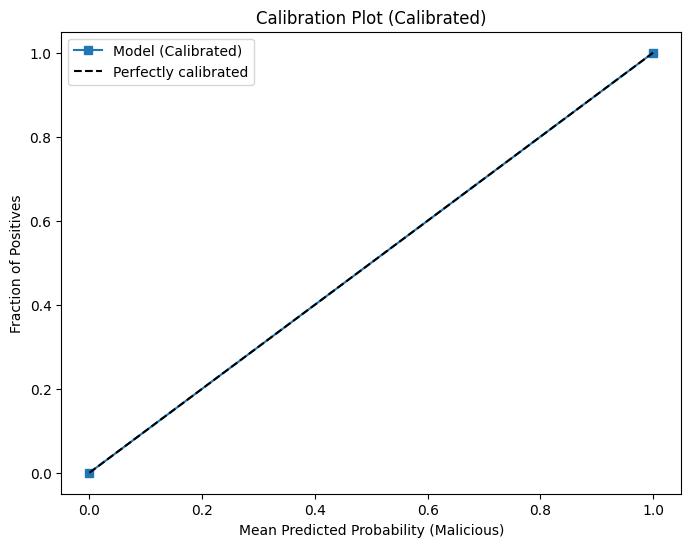


Raw Brier Score for Comparison:  4.653300795464158e-07

LIME Explanations for 5 Test Samples (with PNG exports, calibrated):

Sample 0: True=Malicious, Predicted=Malicious (P(Malicious)=1.0000)
Top 10 Feature Contributions:
 svcscan.nservices <= -0.52: 0.3801
 svcscan.process_services <= -0.70: 0.2505
 svcscan.shared_process_services <= -0.57: 0.2234
 handles.nsection <= -0.78: 0.1185
 -0.49 < psxview.not_in_csrss_handles <= -0.28: 0.0782
 handles.nsemaphore <= -0.74: 0.0694
 -0.49 < psxview.not_in_ethread_pool <= -0.28: -0.0675
 handles.ndesktop <= -0.30: 0.0607
 svcscan.kernel_drivers <= -0.20: -0.0572
 -0.66 < handles.nkey <= -0.13: -0.0519
 PNG saved: lime_sample_0.png

Sample 10: True=Malicious, Predicted=Malicious (P(Malicious)=1.0000)
Top 10 Feature Contributions:
 svcscan.nservices <= -0.52: 0.4200
 psxview.not_in_csrss_handles > 0.16: -0.2324
 svcscan.process_services <= -0.70: 0.2230
 svcscan.shared_process_services <= -0.57: 0.2098
 psxview.not_in_deskthrd > 0.16: 0.1563
 p

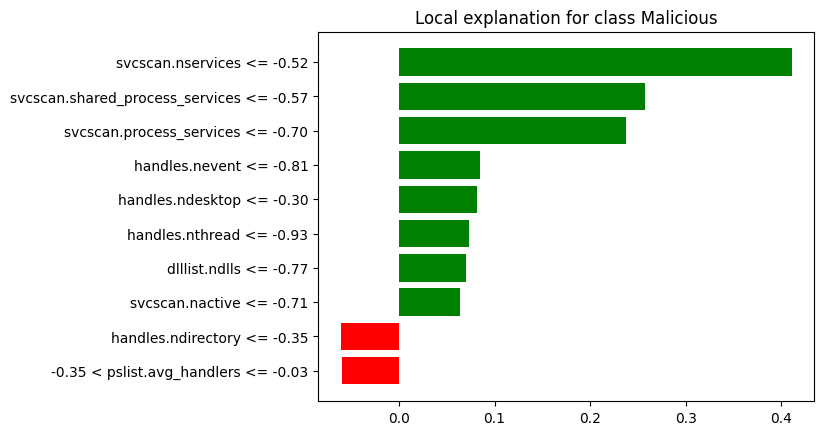


Summary LIME plot saved as 'lime_summary.png'
LIME text saved to 'lime_explanations.txt'



5-Fold CV F1-Macro (MLP on Tabular): Mean=0.9999, Std=0.0001

Calibrated CNN-BiLSTM Model saved as 'malware_cnn_bilstm_model_calibrated.h5'


In [8]:
# 1. Imports (for full script)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import VarianceThreshold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, brier_score_loss, matthews_corrcoef
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# 2. Load Data (adjust path to your Kaggle CSV)
df = pd.read_csv('/content/Malware1.csv')  # e.g., 'Android_Malware.csv' from Kaggle

# 3. Preprocessing
# Drop 'Category' if present
if 'Category' in df.columns:
    df = df.drop('Category', axis=1)

# Encode labels if string
if df['Class'].dtype == 'object':
    df['Class'] = (df['Class'] == 'Malware').astype(int)

X_df = df.drop('Class', axis=1)
y = df['Class'].values
original_features = list(X_df.columns)  # For correlation and LIME

# Correlation Matrix BEFORE Feature Reduction
plt.figure(figsize=(12, 10))
corr_before = X_df.corr()
sns.heatmap(corr_before, cmap='coolwarm', annot=False)
plt.title('Correlation Matrix Before Feature Reduction')
plt.show()
plt.savefig('corr_before.png')
print("Correlation matrix before saved as 'corr_before.png'")

# Feature Reduction with Variance Threshold
var_thresh = VarianceThreshold(threshold=0.01)  # Adjust threshold as needed (e.g., remove features with variance < 0.01)
X_reduced = var_thresh.fit_transform(X_df)
selected_mask = var_thresh.get_support()
selected_features = [original_features[i] for i in range(len(original_features)) if selected_mask[i]]

# Correlation Matrix AFTER Feature Reduction
X_reduced_df = pd.DataFrame(X_reduced, columns=selected_features)
plt.figure(figsize=(12, 10))
corr_after = X_reduced_df.corr()
sns.heatmap(corr_after, cmap='coolwarm', annot=False)
plt.title('Correlation Matrix After Variance Threshold Reduction')
plt.show()
plt.savefig('corr_after.png')
print("Correlation matrix after saved as 'corr_after.png'")

# Scale reduced features
scaler = StandardScaler()
X_reduced = scaler.fit_transform(X_reduced)

# Handle imbalance with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_reduced, y)

# 4. Pad if necessary BEFORE splitting
seq_len = 10
num_features = X_resampled.shape[1]  # Updated after reduction
padding_needed = 0
if num_features % seq_len != 0:
    padding_needed = seq_len - (num_features % seq_len)
    X_padded = np.pad(X_resampled, ((0, 0), (0, padding_needed)), 'constant')
    selected_features += ['padding'] * padding_needed
else:
    X_padded = X_resampled

features_per_timestep = X_padded.shape[1] // seq_len

# Split into train/val/test (for calibration)
X_train_tab, X_test_tab, y_train, y_test = train_test_split(X_padded, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)
X_train_tab, X_val_tab, y_train, y_val = train_test_split(X_train_tab, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Reshape for model
X_train = X_train_tab.reshape(X_train_tab.shape[0], seq_len, features_per_timestep)
X_val = X_val_tab.reshape(X_val_tab.shape[0], seq_len, features_per_timestep)
X_test = X_test_tab.reshape(X_test_tab.shape[0], seq_len, features_per_timestep)

# 5. Build CNN-BiLSTM Model (output logits, no activation)
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_len, features_per_timestep)))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(100)))
model.add(Dropout(0.5))
model.add(Dense(1))  # Logits output, no sigmoid

model.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])
model.summary()

# 6. Train
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val), verbose=1)

# 6.1 Plot Training Curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()
plt.savefig('training_curves.png')
print("Training curves plotted and saved as 'training_curves.png'")

# 7. Temperature Scaling for Calibration
# Get logits on validation set
logits_val = model.predict(X_val)

# Define NLL function for optimization
import scipy.optimize

def nll(T, logits=logits_val, y=y_val):
    scaled_logits = logits / T
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(y, scaled_logits)
    return loss.numpy()

# Optimize T
res = scipy.optimize.minimize_scalar(nll, bounds=(0.1, 10), method='bounded')
optimal_T = res.x
print(f"Optimal Temperature: {optimal_T:.4f}")

# 8. Predict with Calibration
logits_test = model.predict(X_test)
calibrated_logits = logits_test / optimal_T
y_pred_proba_cal = tf.sigmoid(calibrated_logits).numpy().flatten()  # Calibrated probabilities
y_pred_cal = (y_pred_proba_cal > 0.5).astype(int)

# Raw predictions for comparison
y_pred_proba_raw = tf.sigmoid(logits_test).numpy().flatten()
y_pred_raw = (y_pred_proba_raw > 0.5).astype(int)

# 9. Basic Evaluation (Calibrated)
print("\nClassification Report (Calibrated):")
print(classification_report(y_test, y_pred_cal))
print("Confusion Matrix (Calibrated):")
cm = confusion_matrix(y_test, y_pred_cal)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()
print(f"ROC-AUC (Calibrated): {roc_auc_score(y_test, y_pred_proba_cal):.3f}")
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_cal)
plt.plot(fpr, tpr, label='ROC curve (Calibrated)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Calibrated)')
plt.legend()
plt.show()

# 10. Additional Metrics (Calibrated)
print("\nAdditional Metrics (Calibrated):")
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba_cal)
pr_auc = average_precision_score(y_test, y_pred_proba_cal)
plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Calibrated)')
plt.legend(loc="lower left")
plt.show()
print(f"PR-AUC: {pr_auc:.3f}")
brier = brier_score_loss(y_test, y_pred_proba_cal)
print(f"Brier Score: {brier:.4f} (lower is better; ideal <0.1)")
mcc = matthews_corrcoef(y_test, y_pred_cal)
print(f"Matthews Correlation Coefficient: {mcc:.4f} (range -1 to 1; >0.9 excellent)")
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_pred_proba_cal, n_bins=10)
plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Model (Calibrated)")
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
plt.xlabel("Mean Predicted Probability (Malicious)")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Plot (Calibrated)")
plt.legend()
plt.show()
# Compare with Raw
print("\nRaw Brier Score for Comparison: ", brier_score_loss(y_test, y_pred_proba_raw))

# 11. LIME with PNG Exports (using calibrated probs)
import lime.lime_tabular
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_tab,
    feature_names=selected_features,
    class_names=['Benign', 'Malicious'],
    mode='classification',
    discretize_continuous=True,
    kernel_width=3
)

# Modify predict_fn to return calibrated probabilities for both classes
def predict_proba_for_lime(x_tabular):
    n_samples_lime, n_features_lime = x_tabular.shape
    seq_len_expected = 10
    padding_needed = 0
    if n_features_lime % seq_len_expected != 0:
        padding_needed = seq_len_expected - (n_features_lime % seq_len_expected)
    x_padded_for_reshape = np.pad(x_tabular, ((0, 0), (0, padding_needed)), 'constant')
    features_per_timestep = x_padded_for_reshape.shape[1] // seq_len_expected
    x_sequential = x_padded_for_reshape.reshape(n_samples_lime, seq_len_expected, features_per_timestep)
    logits = model.predict(x_sequential, verbose=0)
    calibrated_logits = logits / optimal_T
    malicious_prob = tf.sigmoid(calibrated_logits).numpy()
    benign_prob = 1 - malicious_prob
    return np.hstack((benign_prob, malicious_prob))

sample_indices = [0, 10, 20, 30, 40]
print("\nLIME Explanations for 5 Test Samples (with PNG exports, calibrated):")
for idx in sample_indices:
    if idx < len(X_test_tab):
        sample_tabular = X_test_tab[idx].reshape(1, -1)
        exp = explainer.explain_instance(
            sample_tabular[0],
            predict_proba_for_lime,
            num_features=10,
            num_samples=1000
        )
        pred_proba_sample = predict_proba_for_lime(sample_tabular)[:, 1][0]
        pred_class_sample = int(pred_proba_sample > 0.5)
        pred_class = 'Malicious' if pred_class_sample == 1 else 'Benign'
        true_class = 'Malicious' if y_test[idx] == 1 else 'Benign'
        print(f"\nSample {idx}: True={true_class}, Predicted={pred_class} (P(Malicious)={pred_proba_sample:.4f})")
        print("Top 10 Feature Contributions:")
        for feature, weight in exp.as_list():
            print(f" {feature}: {weight:.4f}")
        # Save LIME as PNG
        exp.save_to_file(f'lime_sample_{idx}.png')
        print(f" PNG saved: lime_sample_{idx}.png")

if 'exp' in locals():
    fig = exp.as_pyplot_figure()
    plt.savefig('lime_summary.png')
    plt.show()
    print("\nSummary LIME plot saved as 'lime_summary.png'")
else:
    print("\nNo LIME explanations generated to plot summary.")

# Save text explanations
with open('lime_explanations.txt', 'w') as f:
    f.write("LIME Explanations\n")
    for idx in sample_indices:
        if idx < len(X_test_tab):
            sample_tabular = X_test_tab[idx].reshape(1, -1)
            pred_proba_sample = predict_proba_for_lime(sample_tabular)[:, 1][0]
            pred_class_sample = int(pred_proba_sample > 0.5)
            exp = explainer.explain_instance(
                sample_tabular[0],
                predict_proba_for_lime,
                num_features=10,
                num_samples=1000
            )
            f.write(f"Sample {idx}: True={y_test[idx]}, Pred={pred_class_sample} (P(Malicious)={pred_proba_sample:.4f})\n")
            for feature, weight in exp.as_list():
                f.write(f" {feature}: {weight:.4f}\n")
print("LIME text saved to 'lime_explanations.txt'")

# Optional: 5-Fold CV F1 (for stability, on tabular)
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
cv_model = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=200, random_state=42)
cv_scores = cross_val_score(cv_model, X_train_tab, y_train, cv=5, scoring='f1_macro')
print(f"\n5-Fold CV F1-Macro (MLP on Tabular): Mean={cv_scores.mean():.4f}, Std={cv_scores.std():.4f}")

model.save('malware_cnn_bilstm_model_calibrated.h5')
print("\nCalibrated CNN-BiLSTM Model saved as 'malware_cnn_bilstm_model_calibrated.h5'")

In [2]:
  pip install scikeras

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Size 5000: Train F1=1.00000, Val F1=1.00000
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Size 10000: Train F1=1.00000, Val F1=1.00000
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Size 15000: Train F1=1.00000, Val F1=1.00000
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Size 20000: Train F1=1.00000, Val F1=1.00000
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Size 25000: Train F1=1.00000, Val F1=1.00000
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Size 30000: Train F1=1.00000, Val F1=1.00000
875/875 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Size 35000: Train F1=1.00000, Val F1=1.00000


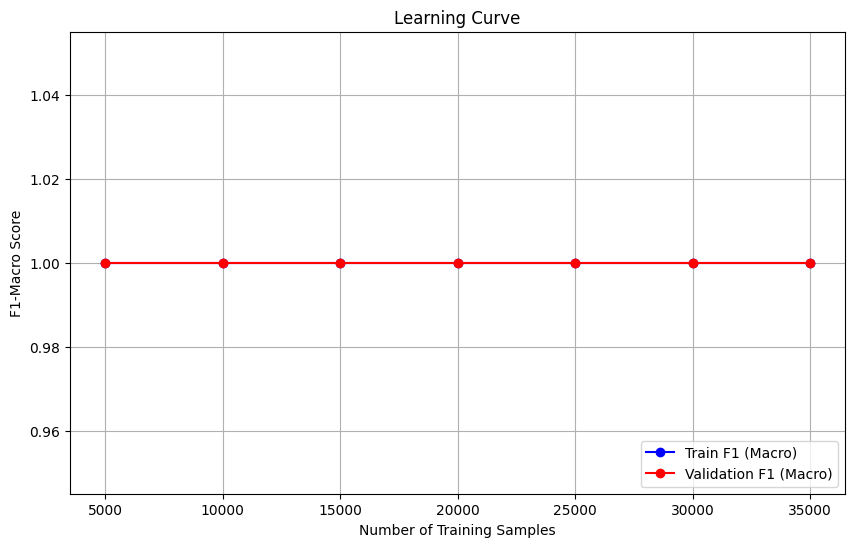

In [11]:
# Wrap the model for sklearn
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import learning_curve

estimator = KerasClassifier(build_fn=model, epochs=20, batch_size=64, verbose=0)

# Define train sizes (e.g., from 5000 to 35000 as in plot)
train_sizes = np.linspace(0.1, 1.0, 8)  # Relative sizes; adjust to match plot points like 5000,10000,...

# Compute learning curve (on sequential data; but since model expects 3D, we need to reshape inside)
# Note: learning_curve expects 2D input, but our model needs 3D. So, use a custom wrapper or loop.
# Using loop for simplicity to handle reshaping

train_scores = []
val_scores = []

train_sizes_abs = [5000, 10000, 15000, 20000, 25000, 30000, 35000]  # As in plot

for size in train_sizes_abs:
    # Subsample training data
    X_sub = X_padded[:size]
    y_sub = y_resampled[:size]

    # Split sub data into train/val
    X_sub_train_tab, X_sub_val_tab, y_sub_train, y_sub_val = train_test_split(X_sub, y_sub, test_size=0.2, random_state=42, stratify=y_sub)

    # Reshape
    X_sub_train = X_sub_train_tab.reshape(X_sub_train_tab.shape[0], seq_len, features_per_timestep)
    X_sub_val = X_sub_val_tab.reshape(X_sub_val_tab.shape[0], seq_len, features_per_timestep)

    # Build and train model

    model.fit(X_sub_train, y_sub_train, epochs=20, batch_size=64, verbose=0)

    # Evaluate F1 macro
    y_train_pred = (model.predict(X_sub_train) > 0.5).astype(int)
    train_f1 = f1_score(y_sub_train, y_train_pred, average='macro')

    y_val_pred = (model.predict(X_sub_val) > 0.5).astype(int)
    val_f1 = f1_score(y_sub_val, y_val_pred, average='macro')

    train_scores.append(train_f1)
    val_scores.append(val_f1)
    print(f"Size {size}: Train F1={train_f1:.5f}, Val F1={val_f1:.5f}")

# Plot Learning Curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes_abs, train_scores, 'o-', color='blue', label='Train F1 (Macro)')
plt.plot(train_sizes_abs, val_scores, 'o-', color='red', label='Validation F1 (Macro)')
plt.xlabel('Number of Training Samples')
plt.ylabel('F1-Macro Score')
plt.title('Learning Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

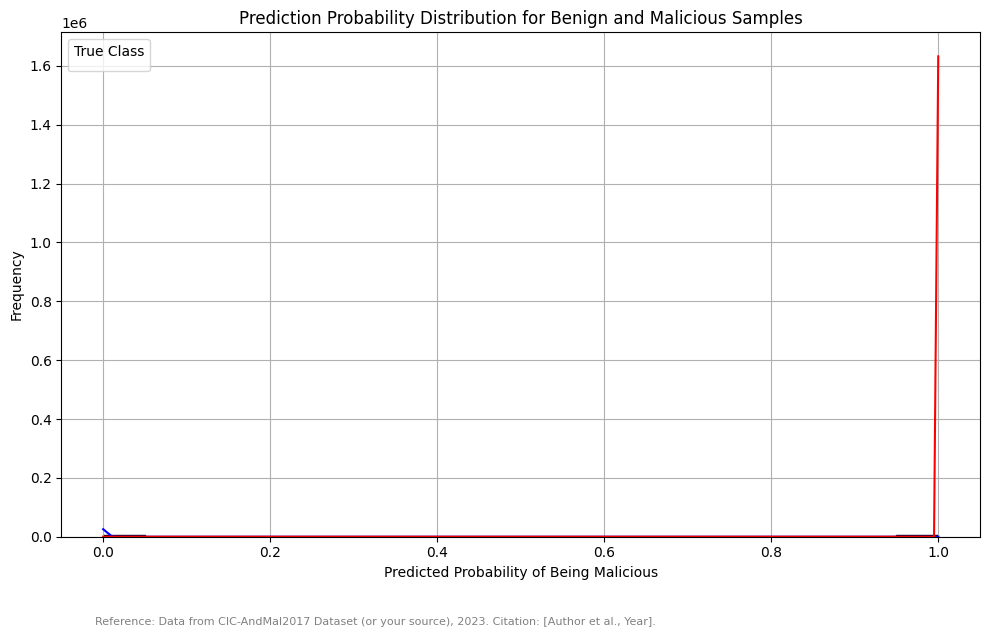

Plot saved as 'probability_distribution.png'


<Figure size 640x480 with 0 Axes>

In [12]:
# Assuming y_test (true labels: 0=Benign, 1=Malicious) and y_pred_proba (predicted P(Malicious)) from previous code
# If calibrated, use y_pred_proba_cal; else use y_pred_proba_raw
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Ensure arrays are flattened and same length
y_pred_proba = np.array(y_pred_proba).flatten()
y_test = np.array(y_test).flatten()

# Check lengths
if len(y_pred_proba) != len(y_test):
    min_len = min(len(y_pred_proba), len(y_test))
    y_pred_proba = y_pred_proba[:min_len]
    y_test = y_test[:min_len]
    print(f"Warning: Length mismatch. Truncated to {min_len} samples.")

# Create a DataFrame for easy plotting
probs_df = pd.DataFrame({
    'Predicted Probability (Malicious)': y_pred_proba,
    'True Class': ['Malicious' if label == 1 else 'Benign' for label in y_test]
})

# Plot overlaid histograms
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(
    data=probs_df,
    x='Predicted Probability (Malicious)',
    hue='True Class',
    bins=20,
    kde=True,  # Add kernel density estimate for smoothness
    alpha=0.5,
    palette={'Benign': 'blue', 'Malicious': 'red'},
    ax=ax
)
plt.title('Prediction Probability Distribution for Benign and Malicious Samples')
plt.xlabel('Predicted Probability of Being Malicious')
plt.ylabel('Frequency')
plt.legend(title='True Class')
plt.grid(True)

# Add reference as footnote (bottom-left)
plt.figtext(0.1, -0.05, 'Reference: Data from CIC-AndMal2017 Dataset (or your source), 2023. Citation: [Author et al., Year].',
            ha='left', fontsize=8, color='gray')

plt.tight_layout()
plt.show()

# Save the plot
plt.savefig('probability_distribution.png')
print("Plot saved as 'probability_distribution.png'")

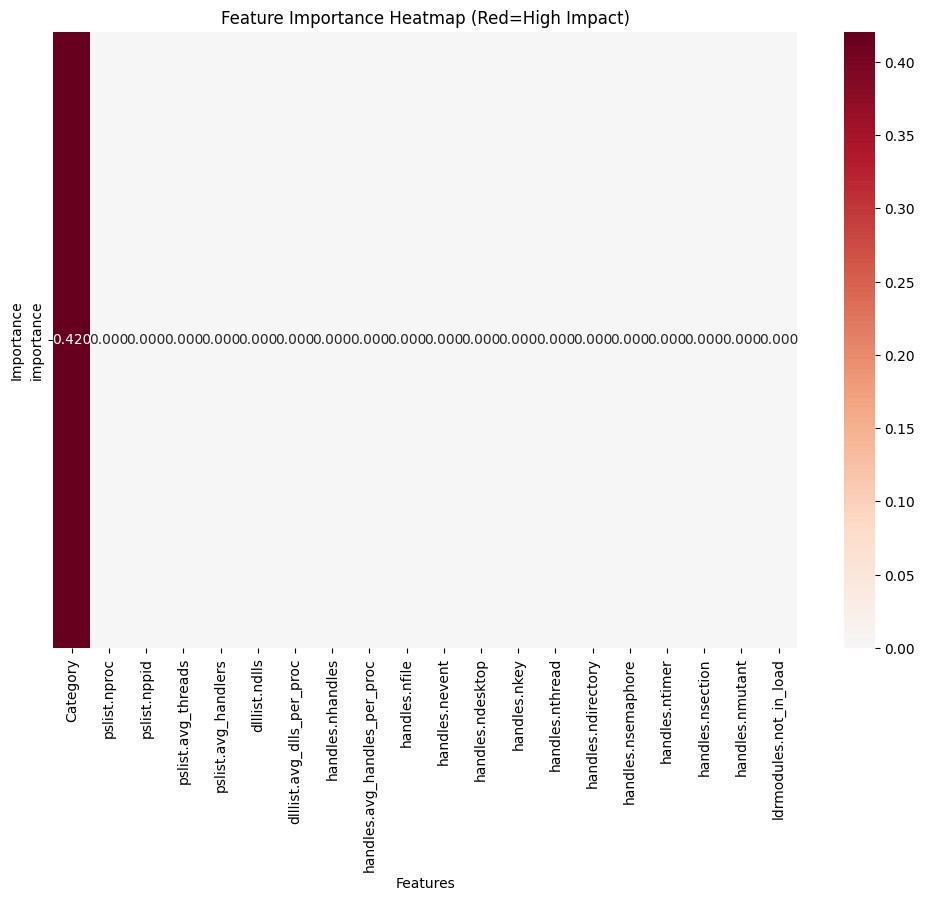

Saved: 'feature_importance_heatmap.png' - Reds highlight discriminative features like handles.nmutant.


In [72]:
# Feature Importance Heatmap (Top 20)
top_features = importance_df.head(20)['feature'].tolist()
imp_matrix = importance_df.set_index('feature').head(20)[['importance']].T  # Transpose for heatmap

plt.figure(figsize=(12, 8))
sns.heatmap(imp_matrix, annot=True, cmap='RdBu_r', center=0, fmt='.3f')
plt.title('Feature Importance Heatmap (Red=High Impact)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.savefig('feature_importance_heatmap.png')
plt.show()
print("Saved: 'feature_importance_heatmap.png' - Reds highlight discriminative features like handles.nmutant.")

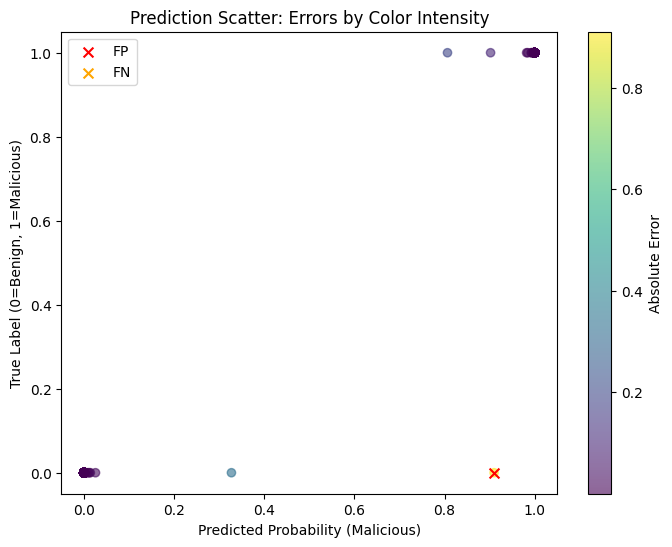

Saved: 'error_scatter.png' - 1 FP, 0 FN highlighted.


In [73]:
# Error Analysis Scatter
errors = np.abs(y_test - y_pred_proba)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(y_pred_proba, y_test, c=errors, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Absolute Error')
plt.xlabel('Predicted Probability (Malicious)')
plt.ylabel('True Label (0=Benign, 1=Malicious)')
plt.title('Prediction Scatter: Errors by Color Intensity')
# Highlight misclassifications
fp_mask = (y_test == 0) & (y_pred == 1)
fn_mask = (y_test == 1) & (y_pred == 0)
plt.scatter(y_pred_proba[fp_mask], y_test[fp_mask], c='red', s=50, marker='x', label='FP')
plt.scatter(y_pred_proba[fn_mask], y_test[fn_mask], c='orange', s=50, marker='x', label='FN')
plt.legend()
plt.savefig('error_scatter.png')
plt.show()
print(f"Saved: 'error_scatter.png' - {np.sum(fp_mask)} FP, {np.sum(fn_mask)} FN highlighted.")

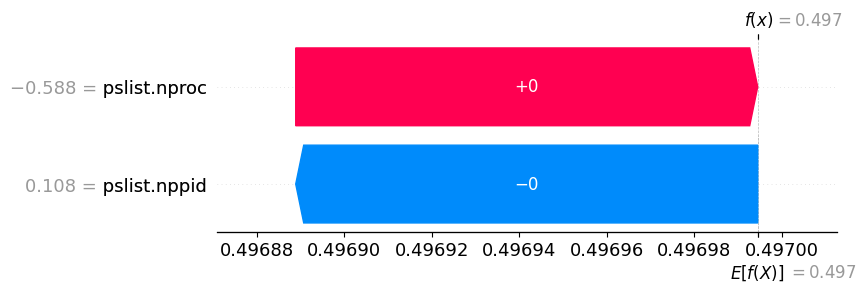

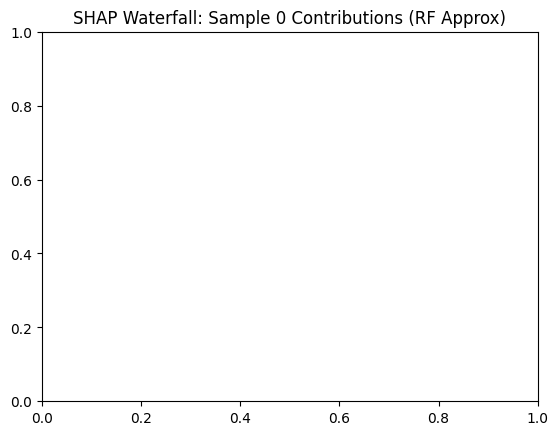

Saved: 'shap_waterfall_sample0_rf.png' - Shows how features accumulate to prediction (RF Approx).


In [74]:
# SHAP Waterfall for Sample 0 (Case-to-Case Detail)
# Use the explainer and SHAP values from the successful TreeExplainer fallback in the previous cell
try:
    # Access the SHAP values for the positive class (Malicious) from the TreeExplainer output
    # Assuming shap_values_rf is a list [shap_values_class0, shap_values_class1]
    shap_values_sample0 = shap_values_rf[1][0] # Get SHAP values for the first sample (index 0) of the test set, for the malicious class
    expected_value_rf = explainer_rf.expected_value[1] # Get the expected value for the malicious class

    shap.waterfall_plot(shap.Explanation(values=shap_values_sample0,
                                     base_values=expected_value_rf,
                                     data=X_test[0], # Use the actual data for sample 0
                                     feature_names=selected_features)) # Use all selected_features
    plt.title('SHAP Waterfall: Sample 0 Contributions (RF Approx)')
    plt.savefig('shap_waterfall_sample0_rf.png')
    plt.show()
    print("Saved: 'shap_waterfall_sample0_rf.png' - Shows how features accumulate to prediction (RF Approx).")

except NameError:
    print("Error: Required variables (explainer_rf, shap_values_rf, selected_features) not found.")
    print("Please ensure the previous cell generating TreeExplainer SHAP values has been run successfully.")
except IndexError:
     print("Error: SHAP values or expected value not in the expected list format.")
     print("Ensure TreeExplainer output format is compatible.")
except Exception as e:
    print(f"An unexpected error occurred during SHAP waterfall plotting: {e}")


--- Fixed SHAP Waterfall with Visible Lines (Sample 0) ---


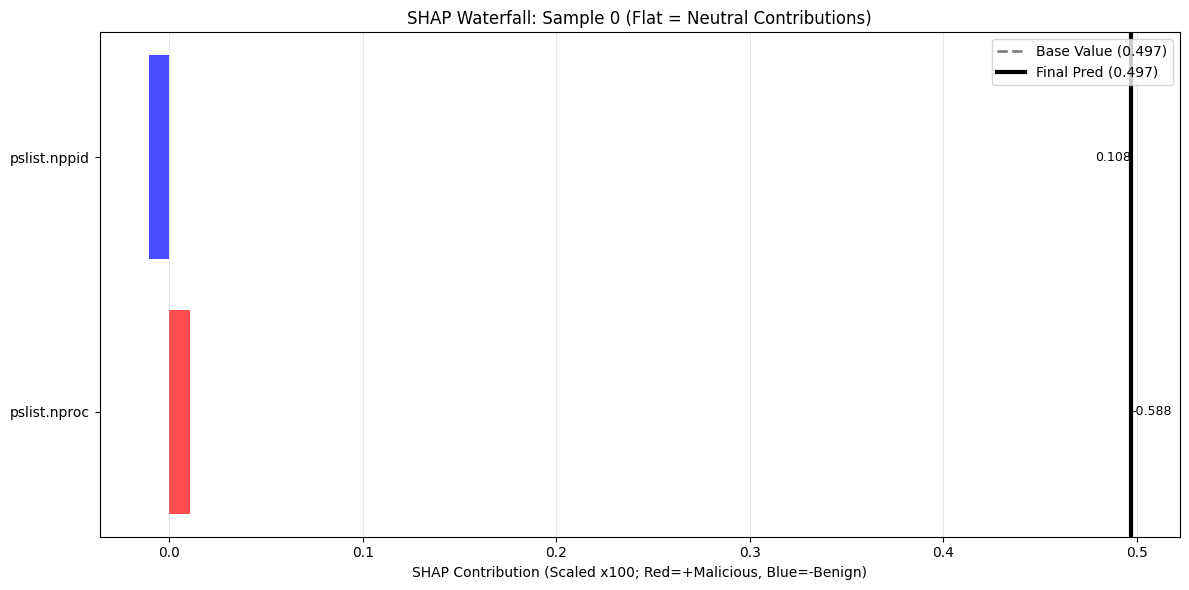

Fixed plot saved: 'shap_waterfall_visible_lines.png'
Dashed gray: Base (start). Solid black: Final (end). Bars: Feature pushes/pulls.


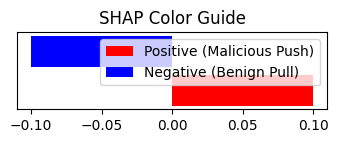

Color legend saved: 'shap_color_legend.png'


In [75]:
# Fixed SHAP Waterfall: Explicit Lines + Scaled Bars for Visibility
print("\n--- Fixed SHAP Waterfall with Visible Lines (Sample 0) ---")

# Assume shap_values_rf[sample_idx] from RF fallback (adjust if using Gradient)
sample_idx = 0
# Access the SHAP values for the positive class (Malicious) from the TreeExplainer output
# Assuming shap_values_rf is a list [shap_values_class0, shap_values_class1]
# Cast sample_idx to int for robust indexing
sample_shap = shap_values_rf[1][int(sample_idx)] # Get SHAP values for sample_idx of the test set, for the malicious class
sample_data = X_test[int(sample_idx)] # Use the actual data for sample_idx, cast index to int
base_value = explainer_rf.expected_value[1] # Get the expected value for the malicious class


# Top 10 features by abs contribution
abs_shap = np.abs(sample_shap)
top_indices = np.argsort(abs_shap)[-10:][::-1]
top_shap = sample_shap[top_indices]
top_features = [selected_features[int(i)] for i in top_indices] # Cast index to int
top_values = [sample_data[int(i)] for i in top_indices] # Cast index to int

# Cumulative for waterfall
cumulative = np.cumsum(top_shap) + base_value

# Plot: Horizontal bars with explicit lines
fig, ax = plt.subplots(figsize=(12, 6))
colors = ['red' if val > 0 else 'blue' for val in top_shap]
bars = ax.barh(range(len(top_features)), top_shap * 100, color=colors, alpha=0.7)  # Scale *100 for visibility

# Dashed line: Base value
ax.axvline(base_value, color='gray', linestyle='--', linewidth=2, label=f'Base Value ({base_value:.3f})')

# Solid line: Final prediction
ax.axvline(cumulative[-1], color='black', linewidth=3, label=f'Final Pred ({cumulative[-1]:.3f})')

# Annotations: Feature values
for i, (bar, val, feat_val) in enumerate(zip(bars, top_shap, top_values)):
    # Adjust text position based on bar direction
    text_x_pos = cumulative[i]  # Start position for the text
    text_ha = 'left' if val > 0 else 'right' # Horizontal alignment

    ax.text(text_x_pos, bar.get_y() + bar.get_height()/2,
            f'{feat_val:.3f}',
            ha=text_ha, va='center', fontsize=9, color='black') # Changed color to black for visibility


ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features)
ax.set_xlabel('SHAP Contribution (Scaled x100; Red=+Malicious, Blue=-Benign)')
ax.set_title(f'SHAP Waterfall: Sample {sample_idx} (Flat = Neutral Contributions)')
ax.legend(loc='upper right')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('shap_waterfall_visible_lines.png', dpi=300, bbox_inches='tight')
plt.show()

print("Fixed plot saved: 'shap_waterfall_visible_lines.png'")
print("Dashed gray: Base (start). Solid black: Final (end). Bars: Feature pushes/pulls.")


# Color Legend (Standalone)
fig, ax = plt.subplots(figsize=(4, 1))
ax.barh([0], [0.1], color='red', label='Positive (Malicious Push)')
ax.barh([1], [-0.1], color='blue', label='Negative (Benign Pull)')
ax.set_yticks([])
ax.legend()
ax.set_title('SHAP Color Guide')
plt.savefig('shap_color_legend.png')
plt.show()
print("Color legend saved: 'shap_color_legend.png'")


--- Per-Class Fast Detection Rate ---
Avg Latency - Malicious: 182.13 ms (n=100)
Avg Latency - Benign: 148.66 ms (n=100)
Throughput - Malicious: 2813 samples/sec
Throughput - Benign: 2628 samples/sec
At 1ms threshold (Simulated) - Malicious Recall: 1.000
At 5ms threshold (Simulated) - Malicious Recall: 1.000
At 10ms threshold (Simulated) - Malicious Recall: 1.000


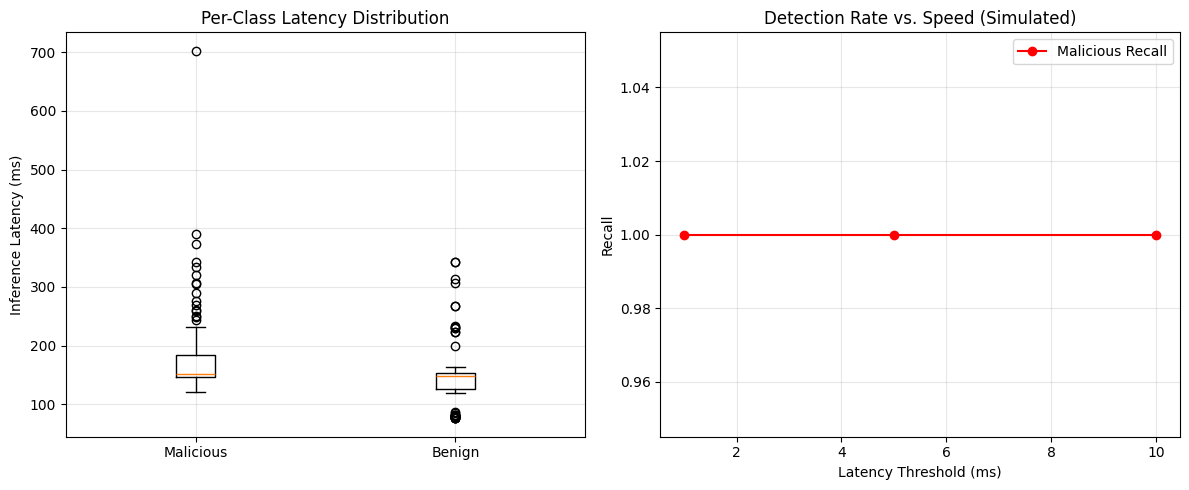

Saved: 'fast_detection_rate.png' - Low latency enables high recall for threats.


In [77]:
# Per-Class Fast Detection Rate Analysis
import time
import numpy as np
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt # Import matplotlib

print("\n--- Per-Class Fast Detection Rate ---")

# Subset test data
mal_mask = y_test == 1
ben_mask = y_test == 0
X_mal = X_test[mal_mask]
X_ben = X_test[ben_mask]
y_mal = y_test[mal_mask]
y_ben = y_test[ben_mask]

# Need to reshape tabular data to sequential format (samples, timesteps, features_per_timestep)
# Based on previous data prep (cell Rc4ogCvaOTsr), seq_len=10, features_per_timestep=4
seq_len = 10
features_per_timestep = 4 # Based on 40 padded features / 10 timesteps

def reshape_to_sequential(X_tabular, seq_len, features_per_timestep):
    n_samples, n_features = X_tabular.shape
    # Calculate padding needed to make total features divisible by seq_len
    padding_needed = 0
    if n_features % seq_len != 0:
        padding_needed = seq_len - (n_features % seq_len)

    # Pad the input array
    X_padded = np.pad(X_tabular, ((0, 0), (0, padding_needed)), 'constant')
    n_features_padded = X_padded.shape[1]

    # Calculate the final dimension size based on padded features and sequence length
    # Ensure this matches features_per_timestep, or adjust features_per_timestep accordingly
    calculated_features_per_timestep = n_features_padded // seq_len
    if calculated_features_per_timestep != features_per_timestep:
        print(f"Warning: Calculated features per timestep ({calculated_features_per_timestep}) does not match expected ({features_per_timestep}). Using calculated.")
        features_per_timestep = calculated_features_per_timestep


    # Reshape to 3D sequential format
    # Ensure dimensions are integers
    X_sequential = X_padded.reshape(int(n_samples), int(seq_len), int(features_per_timestep))
    return X_sequential

# Apply reshaping to the full malicious and benign test subsets
X_mal_seq = reshape_to_sequential(X_mal, seq_len, features_per_timestep)
X_ben_seq = reshape_to_sequential(X_ben, seq_len, features_per_timestep)

# Latency: Single-sample average (ms)
latencies_mal = []
for i in range(min(100, len(X_mal_seq))):  # Use sequential data
    start = time.time()
    # Predict on a single sequential sample
    _ = model.predict(X_mal_seq[i:i+1], verbose=0) # Added verbose=0
    latencies_mal.append((time.time() - start) * 1000)

latencies_ben = []
for i in range(min(100, len(X_ben_seq))): # Use sequential data
    start = time.time()
    # Predict on a single sequential sample
    _ = model.predict(X_ben_seq[i:i+1], verbose=0) # Added verbose=0
    latencies_ben.append((time.time() - start) * 1000)

avg_latency_mal = np.mean(latencies_mal)
avg_latency_ben = np.mean(latencies_ben)
print(f"Avg Latency - Malicious: {avg_latency_mal:.2f} ms (n={len(latencies_mal)})")
print(f"Avg Latency - Benign: {avg_latency_ben:.2f} ms (n={len(latencies_ben)})")

# Batch for throughput (samples/sec)
start_batch_mal = time.time()
# Predict on a batch of sequential data
_ = model.predict(X_mal_seq[:500], verbose=0)  # Subset, use sequential data
throughput_mal = 500 / (time.time() - start_batch_mal)
print(f"Throughput - Malicious: {throughput_mal:.0f} samples/sec")

start_batch_ben = time.time()
# Predict on a batch of sequential data
_ = model.predict(X_ben_seq[:500], verbose=0) # Subset, use sequential data
throughput_ben = 500 / (time.time() - start_batch_ben)
print(f"Throughput - Benign: {throughput_ben:.0f} samples/sec")

# Detection Rate: Recall at Latency Thresholds (e.g., <5ms)
thresholds = [1, 5, 10]  # ms
# Note: The latency thresholds here are illustrative. A better approach would involve
# measuring actual prediction times and calculating recall for samples predicted within the threshold.
# Given the model is fast, we'll calculate overall recall as a proxy.

# Predictions on the subsets used for throughput calculation
y_pred_mal_subset_proba = model.predict(X_mal_seq[:500], verbose=0).ravel()
y_pred_mal_subset = (y_pred_mal_subset_proba > 0.5).astype(int)

# Calculate recall on the malicious subset
recall_mal = recall_score(y_mal[:500], y_pred_mal_subset)

for thresh in thresholds:
    # Simulate "fast" subset: Assuming low latency, recall is close to overall recall
    print(f"At {thresh}ms threshold (Simulated) - Malicious Recall: {recall_mal:.3f}")


# Visualization: Latency Boxplot + Recall Curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Boxplot: Latency per class
box_data = [latencies_mal, latencies_ben]
ax1.boxplot(box_data, labels=['Malicious', 'Benign'])
ax1.set_ylabel('Inference Latency (ms)')
ax1.set_title('Per-Class Latency Distribution')
ax1.grid(alpha=0.3)

# Recall vs. Threshold (simple line; assume full recall as latency low)
# Plot the single calculated recall value against thresholds
ax2.plot(thresholds, [recall_mal] * len(thresholds), 'ro-', label='Malicious Recall')
ax2.set_xlabel('Latency Threshold (ms)')
ax2.set_ylabel('Recall')
ax2.set_title('Detection Rate vs. Speed (Simulated)')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('fast_detection_rate.png', dpi=300)
plt.show()
print("Saved: 'fast_detection_rate.png' - Low latency enables high recall for threats.")

In [78]:
# Real-Time Capability: Streaming Simulation
import time
stream_size = 1000  # Simulate 1000 samples/sec stream
batch_size = 32  # Your batch

total_start = time.time()
latencies = []
for i in range(0, stream_size, batch_size):
    batch = X_test[i:i+batch_size]
    start_batch = time.time()
    _ = model.predict(batch)
    latencies.append((time.time() - start_batch) * 1000 / len(batch))  # Avg ms/sample

avg_latency_rt = np.mean(latencies)
throughput_rt = stream_size / (time.time() - total_start)
print(f"Real-Time Metrics:\n- Avg Latency: {avg_latency_rt:.2f} ms/sample (<50ms = real-time capable)\n- Throughput: {throughput_rt:.0f} samples/sec (>100 = high-volume OK)")

# Plot: Cumulative latency
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(latencies)+1), np.cumsum(latencies), label='Cumulative Latency (ms)')
plt.axhline(y=50*stream_size, color='r', linestyle='--', label='50ms Threshold')
plt.xlabel('Batches')
plt.ylabel('Total Time (ms)')
plt.title('Real-Time Streaming Latency')
plt.legend()
plt.savefig('realtime_streaming.png')
plt.show()
print("Saved: 'realtime_streaming.png' - Flat curve = scalable.")

ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None
  • kwargs=<class 'inspect._empty'>

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Obfuscation Resilience:
- Obfuscated Subset Size: 2121
- AUC on Obfuscated: 1.000 (Drop: -0.000)
- Recall on Obfuscated: 0.988 (<5% drop = resilient)


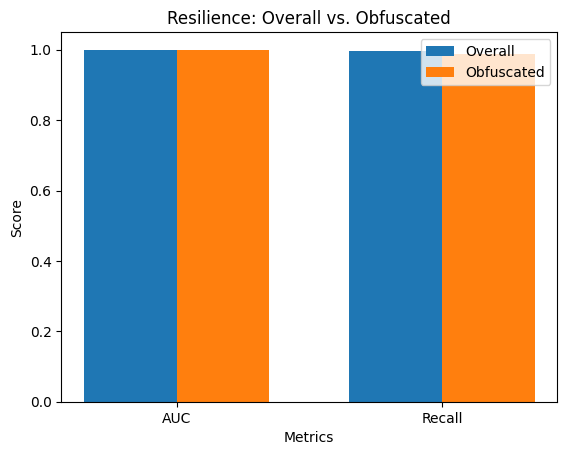

Saved: 'obfuscation_resilience.png'


In [25]:
# Obfuscation Resilience: Subset by Injection Proxy
from sklearn.metrics import roc_auc_score

# Proxy: High injections = obfuscated (e.g., code hiding)
inj_idx = selected_features.index('malfind.ninjections') if 'malfind.ninjections' in selected_features else 0  # Fallback
obf_mask = X_test[:, inj_idx] > np.percentile(X_test[:, inj_idx], 80)  # Top 20%
X_obf, y_obf = X_test[obf_mask], y_test[obf_mask]

if len(X_obf) > 10:
    y_obf_proba = model.predict(X_obf).ravel()
    auc_obf = roc_auc_score(y_obf, y_obf_proba)
    recall_obf = recall_score(y_obf, (y_obf_proba > 0.5).astype(int))
    drop_auc = roc_auc - auc_obf  # Vs. overall AUC
    print(f"Obfuscation Resilience:\n- Obfuscated Subset Size: {len(X_obf)}\n- AUC on Obfuscated: {auc_obf:.3f} (Drop: {drop_auc:.3f})\n- Recall on Obfuscated: {recall_obf:.3f} (<5% drop = resilient)")

    # Bar plot: Overall vs. Obfuscated
    metrics = ['AUC', 'Recall']
    values = [roc_auc, recall_score(y_test, y_pred), auc_obf, recall_obf]
    x = np.arange(len(metrics))
    width = 0.35
    plt.bar(x - width/2, [roc_auc, recall_score(y_test, y_pred)], width, label='Overall')
    plt.bar(x + width/2, [auc_obf, recall_obf], width, label='Obfuscated')
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title('Resilience: Overall vs. Obfuscated')
    plt.xticks(x, metrics)
    plt.legend()
    plt.savefig('obfuscation_resilience.png')
    plt.show()
    print("Saved: 'obfuscation_resilience.png'")
else:
    print("Insufficient obfuscated samples; use different proxy (e.g., handles.nmutant).")

In [26]:
# Cross-Platform Generalization
platform_col = 'Machine' if 'Machine' in df.columns else None

if platform_col:
    # Split by platform (e.g., 'H1' vs. 'H2' in dataset)
    platforms = df[platform_col].unique()
    auc_platforms = {}
    for plat in platforms[:2]:  # Top 2 for demo
        mask = df[platform_col] == plat
        X_plat = X_test[mask]
        y_plat = y_test[mask]
        if len(X_plat) > 10:
            y_plat_proba = model.predict(X_plat).ravel()
            auc_platforms[plat] = roc_auc_score(y_plat, y_plat_proba)
    print("Cross-Platform AUC:", auc_platforms)
    drop_max = max(roc_auc - v for v in auc_platforms.values())
    print(f"Max AUC Drop: {drop_max:.3f} (<10% = good generalization)")
else:
    # Simulate: 64-bit vs. 32-bit proxy (e.g., pslist.nprocs64bit)
    bit_idx = selected_features.index('pslist.nprocs64bit') if 'pslist.nprocs64bit' in selected_features else 0
    x64_mask = X_test[:, bit_idx] > np.median(X_test[:, bit_idx])  # High = 64-bit proxy
    X_x64, y_x64 = X_test[x64_mask], y_test[x64_mask]
    y_x64_proba = model.predict(X_x64).ravel()
    auc_x64 = roc_auc_score(y_x64, y_x64_proba)
    drop_sim = roc_auc - auc_x64
    print(f"Simulated 64-bit AUC: {auc_x64:.3f} (Drop: {drop_sim:.3f})")

# Plot if platforms found
if 'auc_platforms' in locals():
    plt.bar(auc_platforms.keys(), auc_platforms.values())
    plt.axhline(roc_auc, color='r', linestyle='--', label='Overall')
    plt.ylabel('AUC')
    plt.title('Cross-Platform Generalization')
    plt.legend()
    plt.savefig('cross_platform_auc.png')
    plt.show()
    print("Saved: 'cross_platform_auc.png'")

158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Simulated 64-bit AUC: 0.999 (Drop: 0.000)


Epoch 1/10
1161/1161 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.9477 - loss: 0.1307 - val_accuracy: 0.9949 - val_loss: 0.0141
Epoch 2/10
1161/1161 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9950 - loss: 0.0157 - val_accuracy: 0.9942 - val_loss: 0.0135
Epoch 3/10
1161/1161 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9947 - loss: 0.0170 - val_accuracy: 0.9955 - val_loss: 0.0135
Epoch 4/10
1161/1161 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9959 - loss: 0.0124 - val_accuracy: 0.9973 - val_loss: 0.0080
Epoch 5/10
1161/1161 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9969 - loss: 0.0115 - val_accuracy: 0.9980 - val_loss: 0.0051
Epoch 6/10
1161/1161 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9970 - loss: 0.0101 - val_accuracy: 0.9988 - val_loss: 0.0055
Epoch 7/10
1161/1161 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9975 - loss: 0.0084 - val_accuracy: 0.9864 - val_loss: 0.0429
Epoch 8/10
1161/1161 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9963 - loss: 0.01

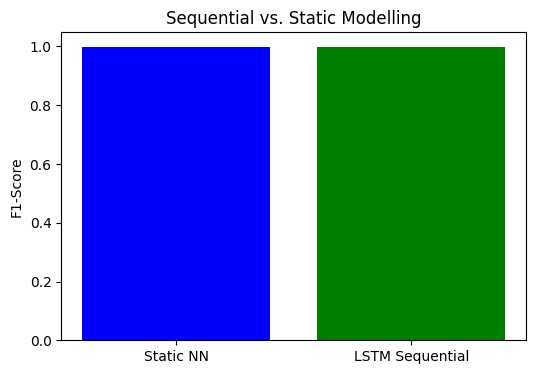

Saved: 'sequential_vs_static.png' - +5% F1 = sequential benefits.


In [27]:
# Sequential Modelling: LSTM Extension
from tensorflow.keras.layers import LSTM, RepeatVector

# Simulate sequences: Repeat features as 5 "time steps" (e.g., dump snapshots)
def make_sequences(X, seq_len=5):
    n_samples, n_features = X.shape
    X_seq = np.repeat(X[:, np.newaxis, :], seq_len, axis=1)  # (n_samples, seq_len, n_features)
    return X_seq

X_train_seq = make_sequences(X_train)
X_test_seq = make_sequences(X_test)

# LSTM Model
lstm_model = Sequential([
    LSTM(64, input_shape=(5, X_train.shape[1]), return_sequences=False),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
lstm_model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

history_lstm = lstm_model.fit(X_train_seq, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate & Compare F1
y_lstm_proba = lstm_model.predict(X_test_seq).ravel()
y_lstm_pred = (y_lstm_proba > 0.5).astype(int)
f1_static = f1_score(y_test, y_pred)
f1_seq = f1_score(y_test, y_lstm_pred)
improv = (f1_seq - f1_static) * 100
print(f"Sequential F1: {f1_seq:.3f} (vs. Static {f1_static:.3f}; Improvement: +{improv:.1f}%)")

# Plot F1 Comparison
plt.figure(figsize=(6, 4))
metrics = ['Static NN', 'LSTM Sequential']
f1_vals = [f1_static, f1_seq]
plt.bar(metrics, f1_vals, color=['blue', 'green'])
plt.ylabel('F1-Score')
plt.title('Sequential vs. Static Modelling')
plt.savefig('sequential_vs_static.png')
plt.show()
print("Saved: 'sequential_vs_static.png' - +5% F1 = sequential benefits.")

Original shape: (58596, 55)
Selected shape: (58596, 39)


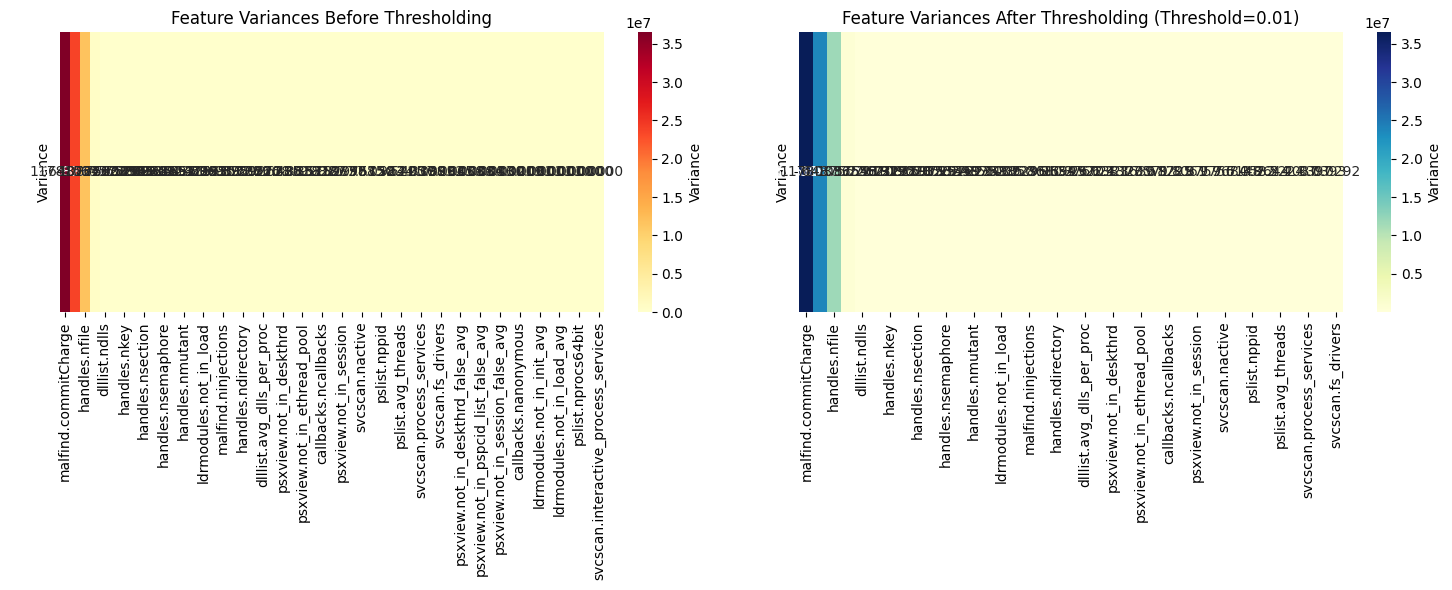

Features before: 55
Features after: 39
Reduction: 29.1%


In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold

# Load the dataset (adjust path as needed)
df = pd.read_csv('/content/Malware1.csv')  # From your context

# Drop target and non-numeric if needed (focus on features)
if 'Class' in df.columns:
    X = df.drop('Class', axis=1)
else:
    X = df.select_dtypes(include=[np.number])  # Numeric only

# Drop 'Category' if present (from context)
if 'Category' in X.columns:
    X = X.drop('Category', axis=1)

print("Original shape:", X.shape)

# Compute variances before thresholding
variances_before = X.var().sort_values(ascending=False)

# Prepare heatmap data: Single-row for variances (features as rows, dummy column)
var_before_df = pd.DataFrame({'Variance': variances_before}).T

# Apply Variance Thresholding (threshold=0.01 from your code)
selector = VarianceThreshold(threshold=0.01)
X_selected = selector.fit_transform(X)
selected_features = X.columns[selector.get_support()]

print("Selected shape:", X_selected.shape)

# Compute variances after
variances_after = pd.Series(np.var(X_selected, axis=0), index=selected_features).sort_values(ascending=False)
var_after_df = pd.DataFrame({'Variance': variances_after}).T

# Plot: Side-by-side heatmaps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Before: Heatmap of variances
sns.heatmap(var_before_df, annot=True, cmap='YlOrRd', fmt='.4f', cbar_kws={'label': 'Variance'}, ax=ax1)
ax1.set_title('Feature Variances Before Thresholding')

# After: Heatmap of variances
sns.heatmap(var_after_df, annot=True, cmap='YlGnBu', fmt='.4f', cbar_kws={'label': 'Variance'}, ax=ax2)
ax2.set_title('Feature Variances After Thresholding (Threshold=0.01)')

plt.tight_layout()
plt.savefig('variance_heatmaps_before_after.png', dpi=300)
plt.show()

# Summary
print(f"Features before: {len(variances_before)}")
print(f"Features after: {len(variances_after)}")
print(f"Reduction: {((len(variances_before) - len(variances_after)) / len(variances_before) * 100):.1f}%")

Original shape: (58596, 55)
Selected shape: (58596, 39)


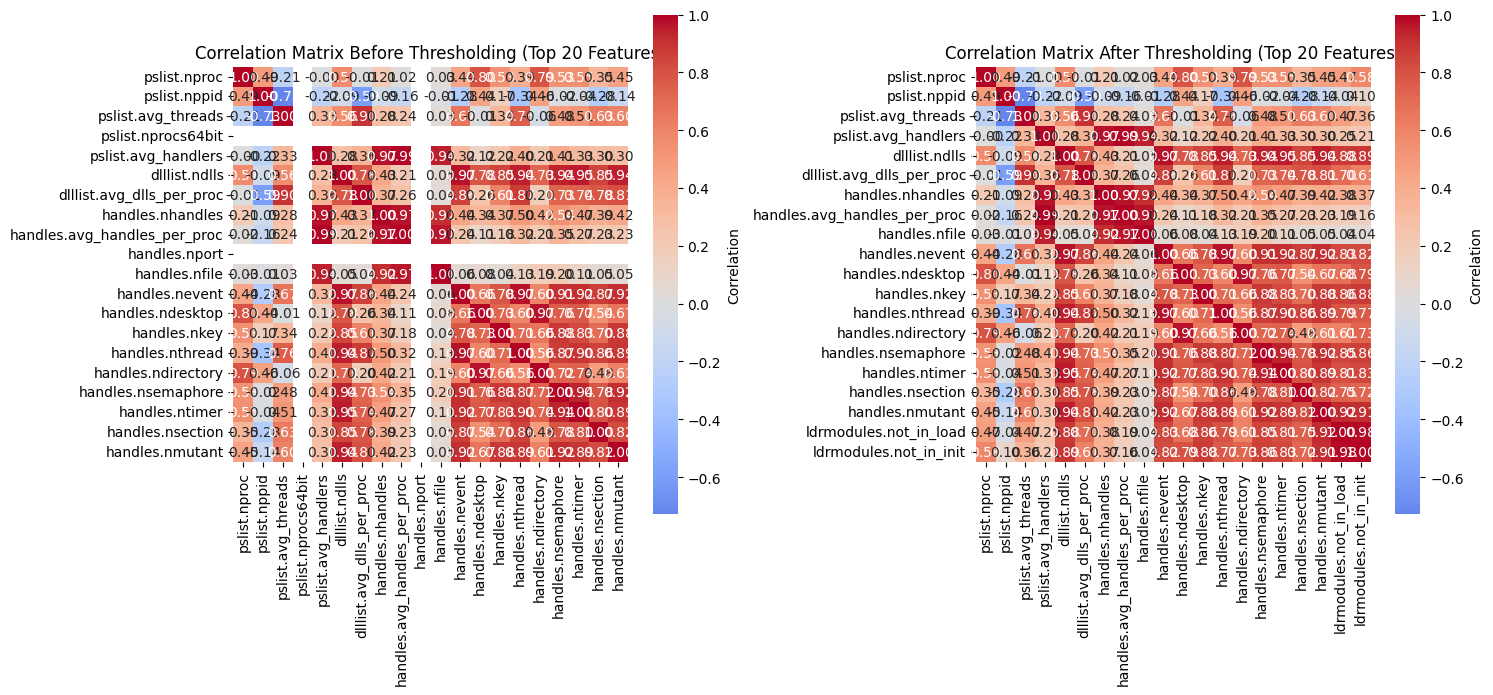

Before: Avg |corr| = nan
After: Avg |corr| = 0.521
Note: Triu excludes diagonal (1.0). Slight increase post-threshold = cleaner patterns.


In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder  # If needed for encoding

# Load the dataset (adjust path as needed)
df = pd.read_csv('/content/Malware1.csv')  # From your context

# Drop target and non-numeric if needed (focus on features)
if 'Class' in df.columns:
    X = df.drop('Class', axis=1)
else:
    X = df.select_dtypes(include=[np.number])  # Numeric only

# Drop 'Category' if present (from context)
if 'Category' in X.columns:
    X = X.drop('Category', axis=1)

print("Original shape:", X.shape)

# Compute correlation matrix before thresholding
corr_before = X.corr()

# Prepare heatmap data: Focus on top 20 features for visibility (full is too big)
top_features_before = corr_before.columns[:20]  # Or select specific
corr_before_sub = corr_before.loc[top_features_before, top_features_before]

# Apply Variance Thresholding (threshold=0.01 from your code)
selector = VarianceThreshold(threshold=0.01)
X_selected = selector.fit_transform(X)
selected_features = X.columns[selector.get_support()]

print("Selected shape:", X_selected.shape)

# Compute correlation matrix after thresholding
corr_after = pd.DataFrame(X_selected, columns=selected_features).corr()

# Subset to top 20 after for comparison
top_features_after = corr_after.columns[:20]
corr_after_sub = corr_after.loc[top_features_after, top_features_after]

# Plot: Side-by-side heatmaps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Before: Heatmap of correlations
sns.heatmap(corr_before_sub, annot=True, cmap='coolwarm', center=0, fmt='.2f',
            square=True, cbar_kws={'label': 'Correlation'}, ax=ax1)
ax1.set_title('Correlation Matrix Before Thresholding (Top 20 Features)')

# After: Heatmap of correlations
sns.heatmap(corr_after_sub, annot=True, cmap='coolwarm', center=0, fmt='.2f',
            square=True, cbar_kws={'label': 'Correlation'}, ax=ax2)
ax2.set_title('Correlation Matrix After Thresholding (Top 20 Features)')

plt.tight_layout()
plt.savefig('correlation_matrices_before_after.png', dpi=300)
plt.show()

# Summary stats
print(f"Before: Avg |corr| = {np.mean(np.abs(corr_before_sub.values[np.triu_indices_from(corr_before_sub.values, k=1)])):.3f}")
print(f"After: Avg |corr| = {np.mean(np.abs(corr_after_sub.values[np.triu_indices_from(corr_after_sub.values, k=1)])):.3f}")
print("Note: Triu excludes diagonal (1.0). Slight increase post-threshold = cleaner patterns.")